In [1]:
import numpy as np
# %matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import colors, cm

from astropy.io import fits, ascii
from astropy.table import vstack 
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import default_cosmology

from scipy.stats import norm, bernoulli, cumfreq
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.integrate import quad

import pandas as pd
import corner, glob, multiprocessing
from multiprocessing import Pool
ncpu = multiprocessing.cpu_count()

In [2]:
lcdm = default_cosmology.get()
!pwd

/Users/mila/Documents/Research/Postdoc/efeds-dwarfAGN


In [3]:
plt.rcParams.update({'font.family':'STIXGeneral'})
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'figure.dpi': 72.0})
plt.rcParams.update({'font.size': 14.0})
plt.rcParams.update({'xtick.labelsize': 14})
plt.rcParams.update({'ytick.labelsize': 14})
plt.rcParams.update({'savefig.dpi': 152})

In [4]:
ptsrc = fits.open('ptsrc_cat.fits')[1].data
ptsrc_lowsig = fits.open('ptsrc_lowsig.fits')[1].data

In [5]:
ptsrc.dtype

dtype((numpy.record, [('ID_SRC', '>i4'), ('RA', '>f8'), ('DEC', '>f8'), ('RADEC_ERR', '>f4'), ('EXT', '>f4'), ('EXT_ERR', '>f4'), ('EXT_LIKE', '>f4'), ('ML_CTS', '>f4'), ('ML_CTS_ERR', '>f4'), ('ML_RATE', '>f4'), ('ML_RATE_ERR', '>f4'), ('ML_FLUX', '>f4'), ('ML_FLUX_ERR', '>f4'), ('DET_LIKE', '>f4'), ('ML_BKG', '>f4'), ('ML_EXP', '>f4'), ('RA_CORR', '>f8'), ('DEC_CORR', '>f8'), ('RADEC_ERR_CORR', '>f8'), ('ML_CTS_s', '>f8'), ('ML_CTS_ERR_s', '>f8'), ('DET_LIKE_s', '>f8'), ('ML_BKG_s', '>f8'), ('ML_EXP_s', '>f8'), ('ML_FLUX_s', '>f8'), ('ML_FLUX_ERR_s', '>f8'), ('ML_RATE_s', '>f8'), ('ML_RATE_ERR_s', '>f8'), ('APE_CTS_s', '>i4'), ('APE_BKG_s', '>f8'), ('APE_EXP_s', '>f8'), ('APE_RADIUS_s', '>f8'), ('APE_POIS_s', '>f8'), ('ML_CTS_u', '>f8'), ('ML_CTS_ERR_u', '>f8'), ('DET_LIKE_u', '>f8'), ('ML_BKG_u', '>f8'), ('ML_EXP_u', '>f8'), ('ML_FLUX_u', '>f8'), ('ML_FLUX_ERR_u', '>f8'), ('ML_RATE_u', '>f8'), ('ML_RATE_ERR_u', '>f8'), ('APE_CTS_u', '>i4'), ('APE_BKG_u', '>f8'), ('APE_EXP_u', '>f8')

In [6]:
allpts = pd.DataFrame()
allpts.insert(0, 'RA', np.hstack((ptsrc['RA'], ptsrc_lowsig['RA'])))
allpts.insert(1, 'DEC', np.hstack((ptsrc['DEC'], ptsrc_lowsig['DEC'])))
allpts.insert(2, 'flux', np.hstack((ptsrc['ML_FLUX_s'], ptsrc_lowsig['ML_FLUX_s'])))
allpts.insert(3, 'xerr', np.hstack((ptsrc['RADEC_ERR'], ptsrc_lowsig['RADEC_ERR'])))
allpts.to_csv('allpts.csv', index=False)

(0.0, 6000.0)

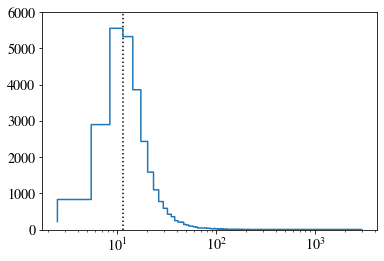

In [7]:
cts = ptsrc['APE_CTS_s'] + ptsrc['APE_CTS_t'] + ptsrc['APE_CTS_u']
hist, bins = np.histogram(cts, bins=1000, range=(1, cts.max()))
x = (bins[:-1]+bins[1:])/2.
plt.step(x, hist)
plt.xscale('log')
plt.vlines(x[np.argmax(hist)], 0, 6000, color='k', linestyle='dotted')
plt.ylim(0,6000)

In [68]:
def crossmatch(cat1, cat2, tab=False, arr=False, ra1='RA', ra2='RA', dec1='DEC', dec2='DEC'):
    inds = []
    if tab:
        for i in range(len(cat1)):
            try:
                inds.append(np.argmin(abs(cat2[ra2] - cat1[ra1][i]) + abs(cat2[dec2] - cat1[dec1][i])))
            except KeyError:
                inds.append(np.argmin(abs(cat2[ra2] - cat1[ra1].iloc[i]) + abs(cat2[dec2] - cat1[dec1].iloc[i])))
    elif arr:
        for i in range(len(cat1)):
            inds.append(np.argmin(abs(cat2[ra2] - cat1[i,0]) + abs(cat2[dec2] - cat1[i,1])))
    else:
        print("invalid data type")
    return inds

In [48]:
gama = pd.read_csv('gama_ssfr.csv', header=0)
gama, sdss
gama_sdss = pd.DataFrame()
gama_sdss.insert(0, 'ra', np.concatenate([gama['RA'].values, sdss['ra'].values]))
gama_sdss.insert(1, 'dec', np.concatenate([gama['DEC'].values, sdss['dec'].values]))
gama_sdss.insert(2, 'z', np.concatenate([gama['Z'].values, sdss['z'].values]))
gama_sdss.insert(3, 'Mstar', np.concatenate([gama['mass_stellar_percentile50'].values, sdss['logMass'].values]))
gama_sdss.insert(4, 'ssfr', np.concatenate([gama['sSFR_0_1Gyr_percentile50'].values, sdss['ssfr'].values-9]))
gama_sdss = gama_sdss.drop_duplicates()
# fitsout = fits.getdata('gals.fits')
# inds = crossmatch(fitsout, gama, ra1='RA', dec1='DEC', tab=True)
# fitsout = fitsout[inds]

# Galaxy Properties

0.08368327025705631


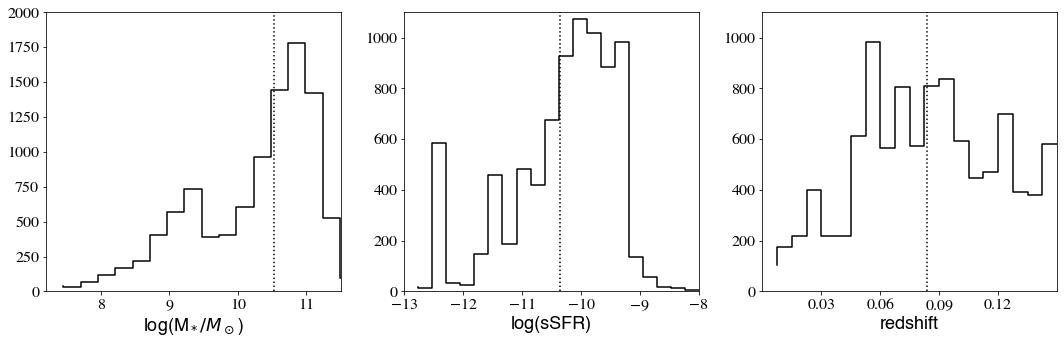

In [50]:
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
font = mpl.font_manager.FontProperties(family='helvetica', size=18)

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax1, ax2, ax3 = ax.flatten()
hist, bins = np.histogram(gama_sdss['Mstar'], bins=21, range=(7.2,12.5))

ax1.step(bins[1:], hist, color='k')
ax1.vlines(x=np.nanmedian(gama_sdss['Mstar']),ymin=0,ymax=2000,color='k',linestyles='dotted')
ax1.set_ylim(0,2000)
ax1.set_xlabel(r'log(M$_*/M_\odot$)', fontsize=16,font=font)
ax1.set_xlim(7.2,11.5)

hist, bins = np.histogram(gama_sdss['ssfr'], bins=21, range=(-13,-8))
ax2.step(bins[1:], hist, color='k')
ax2.vlines(x=np.nanmedian(gama_sdss['ssfr']),ymin=0,ymax=1100,color='k',linestyles='dotted')
ax2.set_ylim(0,1100)
ax2.set_xlabel(r'log(sSFR)', fontsize=16,font=font)
ax2.set_xlim(-13,-8)

zmean = np.mean(gama_sdss['z'])
ax3.vlines(x=zmean,ymin=0,ymax=1100,color='k',linestyles='dotted')
hist, bins = np.histogram(gama_sdss['z'], bins=20, range=(0,0.15))
ax3.step(bins[1:], hist, color='k')
ax3.set_xticks([0.03, 0.06, 0.09, 0.12])
ax3.set_xlim(0,0.15)
bins[np.argmax(hist)]
ax3.set_xlabel(r'redshift', fontsize=16, font=font)
ax3.set_ylim(0,1100)

for a in ax.flatten(): ama = a.get_ylim()[1]; a.set_ylim(0,ama)
for a in [ax1,ax2, ax3]: a.set_ylabel('')


fig.tight_layout()
print(zmean)
plt.savefig('galaxy-props.png', dpi=156)

In [13]:
def radec_to_pix(ra, dec, head):
    
    ra0 = head['CRVAL1']  #  =  1.3386000000000E+02                                                  
    rap0 = head['CRPIX1'] #  =  1.1249500000000E+04                                                  
    dra = head['CDELT1']  #  = -1.1111111276679E-03                                                  
    dec0 = head['CRVAL2'] #  =  1.5000000000000E+00                                                  
    decp0 = head['CRPIX2']#  =  7.4995000000000E+03                                                  
    ddec = head['CDELT2'] #  =  1.1111111276679E-03  
    
    rapix = (ra - ra0)/dra + rap0
    decpix = (dec - dec0)/ddec + decp0
    
    return rapix, decpix

In [14]:
sdss = pd.read_csv('/Users/mila/Downloads/Skyserver_SQL4_11_2022 10_11_02 PM.csv', header=1)
sdss

,logMass,ssfr,ra,dec,z,sigmaStars
0,10.340919,-0.807768,146.59272,-0.760256,0.064959,66.31586
1,7.281666,-0.287520,146.56561,-1.084742,0.097570,144.94970
2,10.365287,-2.235996,146.90125,-0.413157,0.056548,121.72390
3,11.068292,-6.616292,146.74794,-0.268282,0.130222,130.59850
4,11.171318,-3.408298,145.80475,-1.184054,0.145738,203.37230
...,...,...,...,...,...,...
8240,9.292020,-0.393058,136.44663,4.310656,0.129029,72.62148
8241,11.237734,-33.000000,146.11400,3.054930,0.093225,185.79430
8242,10.929508,-1.718030,128.35948,4.159832,0.066806,113.08190
8243,11.387269,-3.408298,130.23869,1.201568,0.139029,262.27150


In [106]:
# img = fits.getdata('../eFEDS-galaxies/img_0520_excl_grp_pts.fits')
# head = fits.getheader('../eFEDS-galaxies/img_0520_excl_grp_pts.fits')
# rapix, decpix = radec_to_pix(gama_all['RA'],gama_all['DEC'], head)
# sdssra, sdssdec = radec_to_pix(sdss['ra'],sdss['dec'], head)

In [1583]:
def rebin( a, newshape ):
        '''Rebin an array to a new shape.
        '''
        assert len(a.shape) == len(newshape)

        slices = [ slice(0,old, float(old)/new) for old,new in zip(a.shape,newshape) ]
        coordinates = np.mgrid[slices]
        indices = coordinates.astype('i')   #choose the biggest smaller integer index
        return a[tuple(indices)]
    
imgre = rebin(img, (2857,2857))

In [1614]:
head['CRPIX2'],head['CRVAL2']

(7499.5, 1.5)

In [1628]:
ratix = np.array([125,130,135,140,145])
dectix = np.array([-2,0,2,4,6]) #well, clearly this is wrong. 
xtix, ytix = radec_to_pix(ratix, dectix, head)

c = SkyCoord(ra=ratix*u.deg, dec=dectix*u.deg)

([<matplotlib.axis.YTick at 0x7ff18b39c8b0>,
 [Text(0, 4349.500046938496, '-0ʰ08ᵐ00ˢ'),
  Text(0, 6149.5000201164985, '0ʰ00ᵐ00ˢ'),
  Text(0, 7949.4999932945, '0ʰ08ᵐ00ˢ'),
  Text(0, 9749.499966472504, '0ʰ16ᵐ00ˢ'),
  Text(0, 11549.499939650505, '0ʰ24ᵐ00ˢ')])

/Users/mila/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 7504 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mila/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 7504 missing from current font.
  font.set_text(s, 0, flags=flags)


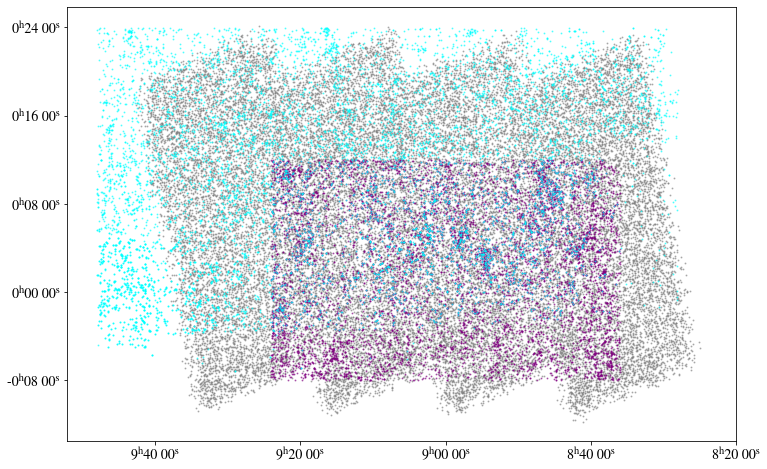

In [1646]:
fig, ax = plt.subplots(figsize=(12,8))
ptsra, ptsdec = radec_to_pix(allpts['RA'], allpts['DEC'], head)
plt.scatter(ptsra, ptsdec, alpha=0.5, color='gray',s=1)
plt.scatter(rapix, decpix , color='purple', alpha=0.5, s=1)
plt.scatter(sdssra, sdssdec , color='cyan', alpha=0.5, s=1)
plt.xticks(xtix, c.ra.to_string(unit=u.hourangle, fields=3, format='unicode'))
plt.yticks(ytix, c.dec.to_string(unit=u.hourangle, fields=3, format='unicode'))
# plt.grid(True)

In [112]:
inds = crossmatch(cat1=gama_sdss, cat2=allpts, ra1='ra', dec1='dec', tab=True)
offset = np.sqrt((allpts.iloc[inds]['RA'].values - gama_sdss['ra'].values)**2 + 
                 (allpts.iloc[inds]['DEC'].values - gama_sdss['dec'].values)**2)*3600

In [116]:
offset.min(), offset.max()

(0.3219230492260981, 10710.218243412051)

(0.0, 400.0)

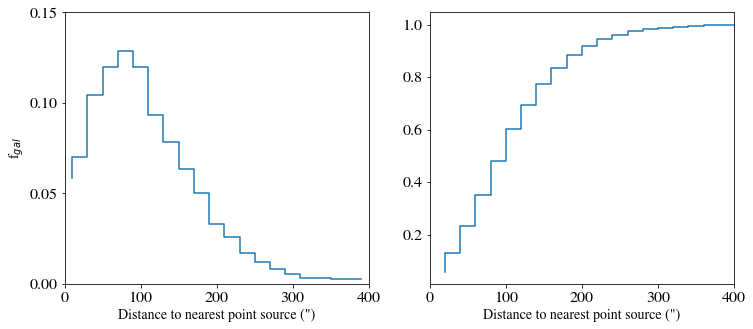

In [128]:
hist, bins = np.histogram(offset, range=(0, 400), bins=20)
hist2, left, w, _ = cumfreq(offset, numbins=20, defaultreallimits=(0,400))
x = left + np.arange(1, len(hist2)+1)*w
fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(12,5))
ax[0].step((bins[:-1] + bins[1:])/2., hist/sum(hist))
ax[1].step(x, hist2/hist2.max())
ax[0].set_yticks([0,.05,.1,.15,.2,.25,.3, .35])
for a in ax.flatten():
    a.set_xlabel('Distance to nearest point source (")', fontsize=14)
ax[0].set_ylim(0,.15)
ax[0].set_ylabel(r'f$_{gal}$', fontsize=14)
plt.xlim(0,400)

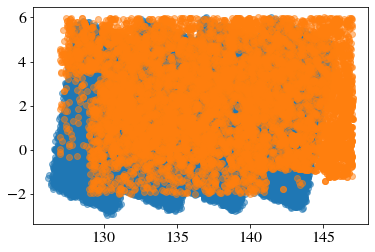

In [61]:
plt.scatter(allpts['RA'], allpts['DEC'], alpha=0.5)
plt.scatter(gama_sdss['ra'], gama_sdss['dec'], alpha=0.5)

In [164]:
# inds = np.argwhere((offset.values < 1))[:,0]#
# pts_1_arcsec = gama[inds]
# inds = np.argwhere((offset.values > 1)*(offset.values < 2))[:,0]#
# pts_1_2_arcsec = gama[inds]
# inds = np.argwhere((offset.values > 2)*(offset.values < 5))[:,0]#
# pts_2_5_arcsec = gama[inds]
# inds = np.argwhere((offset.values > 5)*(offset.values < 10))[:,0]#
# pts_5_10_arcsec = gama[inds]
# inds = np.argwhere((offset.values > 10))[:,0]#
# pts_10_arcsec = gama[inds]

In [346]:
reg = []
for gal in ascii.read('gama-3e9-3e10.csv', delimiter=','):
    c = SkyCoord(ra = gal['RA'], dec = gal['DEC'], unit = (u.degree))
    c = c.to_string('hmsdms').replace('h',':').replace('m',':').replace('d',':').replace('s ',',').replace('s','')
    reg.append("box("+c+",2',2')")

with open('gal_3e9_3e10.reg', 'w') as f:
    f.writelines(reg)

In [129]:
def image_crossmatch(files, master, name='gal_props.csv'):
    radec = np.zeros((len(files),2))
    for i in range(len(files)):
        h = fits.getheader(files[i])
        for line in h['HISTORY']:
            if ('CONT' in line) and ('x(' in line):
                c = SkyCoord(line.split('(')[1].split(',')[0]+' '+line.split(',')[1], unit=(u.hourangle, u.deg))
                radec[i] = (c.ra.to('deg').value, c.dec.to('deg').value)
    sub = pd.DataFrame()
    sub.insert(0, 'ind', [file.split('_')[-1].split('.')[0] for file in files])
    sub.insert(1, 'ra', radec[:,0])
    sub.insert(2, 'dec', radec[:,1])
    inds = crossmatch(sub, master, tab=True)
    sub.insert(3,'mass_stellar_best_fit', master.iloc[inds]['mass_stellar_best_fit'].values)
    sub.insert(4,'sSFR_best_fit', master.iloc[inds]['sSFR_0_1Gyr_best_fit'].values)
    sub.insert(5,'z', master.iloc[inds]['Z'].values)
    sub.to_csv(name, index=False)    

# Stacked images

In [130]:

def stacked_image(files, lenx, leny, inputtype='file'):
	img = np.zeros((lenx, leny))
	i = 0
	for file in files:
		if inputtype == 'file':
			f = fits.getdata(file)
		else:
			f = file
		x, y = f.shape
		# print(x,y)
		if y:
			starty = int((leny - y)/2)
			endy = starty+y
			startx = int((lenx - x)/2)
			endx = startx+x
			img[startx:endx,starty:endy] += f
	return img

In [131]:
def axisticks(ax, tfile, xmin, xmax, x=True, y=True, tickmax=400, ntix=5, fontsize=14, fac=1):
	xtix = np.linspace(-tickmax, tickmax, ntix)
	dx = fits.getheader(tfile)['CDELT1']*fac
	xpos = xtix/dx + (xmin+xmax)/2.
	if x:
		ax.set_xticks(xpos)
		ax.set_xticklabels(['%d' % x for x in xtix], fontsize=fontsize)
	if y:
		ax.set_yticks(xpos)
		ax.set_yticklabels(['%d' % x for x in xtix], fontsize=fontsize)

In [132]:
def save_stacks(tabname='gal_props.csv', mmin=[7, 8, 8.5, 9, 9.25, 9.5]):
    gals = pd.read_csv(tabname, header=0)
    ms = gals['mass_stellar_best_fit']
    for i in range(len(mmin) - 1):
        files = ['cut_0520_%d.fits' % ind for ind in gals[(ms > 10**mmin[i]) * (ms < 10**mmin[i+1])]['ind'].values]
        print(len(files))
        f = fits.getdata('cut_0520_0.fits')
        x, y = f.shape
        im = stacked_image(files, x, y)
        np.save('img-%0.2f-%0.2f.npy' % (mmin[i], mmin[i+1]), im)

In [133]:
def annulus(array, rmin, rmax):
    x = np.arange(array.shape[0])
    y = np.arange(array.shape[1])
    x = x - x.mean()
    y = y - y.mean()
    X, Y = np.meshgrid(x,y)
    r2 = X**2 + Y**2 
#     print(rmin**2, rmax**2, r2)
    return np.argwhere((r2 > (rmin**2))*(r2 < (rmax**2)))

In [253]:
#next let's subtract XRBs

In [134]:

path='../eFEDS-galaxies/' #/data/gnarming/uchadaya/eFEDS/ if on hea comp
cdf = np.mean(np.mean(fits.getdata(path+'psf1.fits'), axis=1), axis=1)
eef = np.arange(0.4, 1.0, 0.05)
sb = eef/(np.pi*cdf**2)
area = np.pi * (cdf[1:]**2 - cdf[:-1]**2)
dE = eef[1:] - eef[:-1]
sb[1:] = dE / area
sb /= sb[0]
xcdf = (cdf[1:] + cdf[:-1])/2
xcdf = np.insert(xcdf,0,cdf[0]/2)

def psf_curve(r, A, rs, beta):
	return A * (1 + (r/rs)**2)**(-beta) #Moffat function, beta=2.0 fitted for XMM

def psf_area(r, A, rs, beta): 
	#integrating this from r1 to r2 should give me the fraction of photons enclosed between those radii
		#IF THE PSF IS PROPERLY NORMALISED
		#in other words, integrating this gives the factor that the raw PSF should be normalised by. 
	return 2*np.pi*r * psf_curve(r, A, rs, beta) #

"MODIFY THIS SO IT COMPUTES DA FOR GIVEN SAMPLE"
"I COULD DO IT IN ARCSEC HERE AND CONVERT TO KPC LATER"
xcdf *= 4

fit, _ =  curve_fit(psf_curve, xcdf, sb)
area_psf, _ = quad(psf_area, args=(fit[0],fit[1], fit[2]), a=0, b=np.infty) 
xp = np.arange(0,100,.1) #in arcsec 
yp = psf_curve(xp, *fit)/area_psf

def Lxrb(sdss, alpha = 6.713e+28, beta = 2.552e+39, low=False, high=False):  #alpha in erg/s/Msun, beta in erg/s/Msun/yr)
	# Lehmer et al. 2019
    #their values are for 0.5-8keV. I use PIMMS to convert this to 0.5-2.0 keV, for ACIS, APEC using photon index = 1.7
    #ok now note. **This beta is too high.** In all the analyses use Mineo instead, 1.62e39. 
	if low:
		alpha = 5.983672482257647e+28, 
		beta = 1.8922033816407476e+39
	if high:
		alpha = 7.888016571050706e+28
		beta = 3.605519214113673e+39
	mstar = sdss['mass_stellar_best_fit']
	sfr = sdss['sSFR_0_1Gyr_best_fit'] * mstar
	return alpha*mstar + beta*sfr


In [135]:
def xrb_psf(sdss, r, alpha = 9.05e28, beta = 1.62e39, fit=fit, area_psf=area_psf):
		norm = Lxrb(sdss).mean()
		yp = psf_curve(r, *fit)/area_psf
		return yp*norm

In [176]:
def plot_all(mmin, gama, fits, rmin=12.5, rmax=18.5, ret=True, save=False, fzmax=3,
             zlim=None, dirs = './', nrows=1, figsize=(16,12), sigma=0, central_flux = False): 
    files = ['img-%0.2f-%0.2f.npy' % (mmin[i], mmin[i+1]) for i in range(len(mmin) - 1)]
    if figsize:
        fig, ax = plt.subplots(nrows = nrows, ncols=int(len(files)/nrows), sharex=True, sharey=True, figsize=figsize)
        fig.subplots_adjust(bottom=0, top=1, left=0, right=0.8)
        cb_ax = fig.add_axes([0.9, 0.1, 0.02, .8])
    ms = np.log10(gama['mass_stellar_best_fit'])
    if central_flux:
        fx_core = []
    for i in range(len(dirs)):
        for j in range(len(files)):
            im = np.load(dirs[i]+files[j])
            bck_inds = annulus(im, rmin, rmax)
            bck = np.nanmedian(im[bck_inds])

            tab = gama[(ms > mmin[i]) * (ms < mmin[i+1])]
            fitscut = fits[(ms > mmin[i]) * (ms < mmin[i+1])]
            exp = fitscut['MEAN_SRC_EXP']/5. 
            sb = (im-bck) / np.nansum(exp)
            
            dl2 = 4*np.pi*(lcdm.luminosity_distance(tab['Z']).to('cm'))**2
            dA2 = (lcdm.angular_diameter_distance(tab['Z']).to('kpc').value*u.arcsec.to('radian'))**2
            sb *= cts_to_erg * dl2.value.mean() / dA2.mean()
            
            x = np.arange(sb.shape[0])*4 #pix to arcsec, to match input for XRBxPSF above
                    #confirmed: PSF is in pixels. See eSASS cookbook
            y = np.arange(sb.shape[1])*4
            X, Y = np.meshgrid((x - x.mean()), (y - y.mean()))
            r = np.sqrt(X**2 + Y**2)
            xrb = xrb_psf(tab, r)
            xm, ym = x.mean()/4, y.mean()/4
            sb = ndimage.gaussian_filter(sb - xrb, sigma=sigma, order=0)
            if figsize:
                if not len(zlim):
                    zlim = np.zeros((len(files)))
                if not i and not zlim.sum():
                    zlim[j] = fzmax*sb.max()
                if i > 1:
                    img = ax[i][j].imshow(sb, origin='lower', cmap=cm.RdBu_r, norm=colors.Normalize(-zlim[j], zlim[j]))
                    if not (i+j):
                        plt.colorbar(img, cax=cb_ax, aspect=10)
                    if not j:
                        ax[i][j].set_ylabel(dirs[len(dirs)-i-1])
                else:
                    img = ax.flatten()[j].imshow(sb, origin='lower', cmap=cm.RdBu_r, norm=colors.Normalize(-zlim[j], zlim[j]))
                    if not j:
                            plt.colorbar(img, cax=cb_ax, aspect=10)
                            if len(dirs) > 1:
                                ax.flatten()[j].set_ylabel(dirs[0])
                src_circle = plt.Circle((xm, ym), rmin, fill=False, color='k', linestyle='dotted')
                bck_circle = plt.Circle((xm, ym), rmax, fill=False, color='k', linestyle='dotted')
                ax.flatten()[j].add_patch(src_circle)
                ax.flatten()[j].add_patch(bck_circle)
            if central_flux:
                fx_core.append(np.mean(sb[int(xm - central_flux):int(xm + central_flux), int(ym - central_flux):int(ym + central_flux)]))
    if save:
        plt.savefig('rawstacks.png')
    if central_flux:
        return fx_core
    else:
        return fig, ax

<ipython-input-150-0ea463055bcd>:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,.9,1])


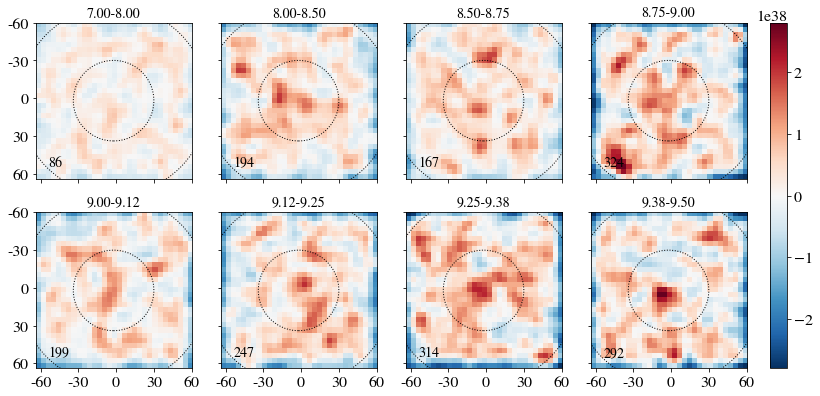

In [150]:
zlim = np.ones(8)
zlim *= 2.8e38
mmin = [7,8,8.5, 8.75, 9, 9.125, 9.25, 9.375, 9.5]
fig, ax = plot_all(gama=gama, fits=fitsout, mmin=mmin, rmin = 8, rmax=18.75, fzmax=1, 
                   dirs=['./'], figsize=(12,6), nrows=2, sigma=1,zlim=zlim)
for i in range(2):
    axisticks(ax[i][0], 'pts_1_2arcsec/cut_0520_0.fits', 0, 31, x=False, tickmax=60, fac=3600, fontsize=16)
for i in range(4):
    axisticks(ax[1][i], 'pts_1_2arcsec/cut_0520_0.fits', 0, 31, y=False, tickmax=60, fac=-3600, fontsize=16)
# ax[0].set_title('7 < $\log(M_*/M_\odot)$ < 8', fontsize=15)
fig.tight_layout(rect=[0,0,.9,1])
for i in range(len(ax.flatten())):
    ax.flatten()[i].set_title('%0.2f-%0.2f' % (mmin[i], mmin[i+1]), fontsize=14)
    ms = np.log10(gama['mass_stellar_best_fit'])
    ngals = len(gama[(ms > mmin[i]) * (ms < mmin[i+1])])
    ax.flatten()[i].text(2, 2, '%d' % ngals, fontsize=14)
ax = np.ravel(ax)
ax = np.reshape(ax,(2,4))

In [207]:
#so really this is what I should be feeding into emcee, rather than the 7600 GAMA objects with plenty of duplicates.
# allobs.to_csv('gama_sdss_all.csv', index=False)
# I could convert sigma to Mbh, no?
def logMbh(sigma): #assuming sigma in km/s
    return 8.15 + 5.58*np.log10(sigma/200)
def log_Mbh_Mstar(Mstar, alpha=8.56,beta= 1.34,eps= 0.17):
    average = alpha + beta*np.log10(Mstar/1e11)
    return np.array([max(0,norm(loc = av, scale=eps).rvs(size=1)[0]) for av in average])    

In [201]:
gama_spec = pd.read_csv('gama_spec.csv', header=0)
gama_sigma = fits.getdata('VelocityDispersionsv01-2021-10-01.fits')
sigmas = np.zeros(len(gama_spec))
for i in range(len(sigmas)):
    try:
        ind = np.argwhere(gama_sigma['CATAID']==gama_spec['CATAID'][i])[0]
        sigmas[i] = gama_sigma['SIGSTAR'][ind]
    except IndexError:
        continue

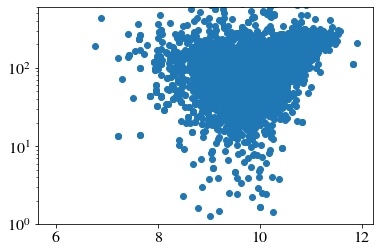

In [206]:
plt.scatter(np.log10(gama_spec['mass_stellar_best_fit']), sigmas)
plt.ylim(1,600)
plt.yscale('log')
#ok clearly there is a LOT of scatter here, and at low masses only the galaxies with highest vdisp are seen by GAMA

In [210]:
# gama_spec.insert(4, 'vstar', sigmas)
mbh = np.zeros(len(xmin))
for i in range(len(xmin)):
    cut = gama[(gama['mass_stellar_percentile50'] > xmin[i])*(gama['mass_stellar_percentile50'] < xmax[i])]
#     indspc = crossmatch(cut, gama_spec, ra2='RA',dec2='DEC', tab=True)
#     sigma = gama_spec.iloc[indspc]['vstar']
    mbh[i] = np.mean(log_Mbh_Mstar(cut['mass_stellar_best_fit']))
mbh #much better!

array([4.11394529, 4.9232884 , 5.42318596, 5.7164142 , 5.95688712,
       6.12927884, 6.28336569, 6.38965327])

Text(0.5, 0, 'log(M$_*$/M$_\\odot$)')

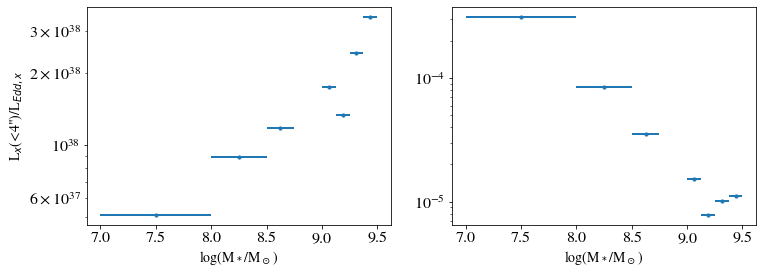

In [214]:
Ledd = 1.26e38 * 10**mbh
Ledd_x = .1*Ledd
fx_core = plot_all(gama=gama, fits=fitsout, mmin=mmin, rmin = 8, rmax=18.75, fzmax=1, figsize=None, ret=True, central_flux=1, dirs=[''],zlim=None)
xmin = np.array([7,8, 8.5, 8.75, 9, 9.125, 9.25, 9.375])
xmax = np.array([8, 8.5, 8.75, 9, 9.125, 9.25, 9.375, 9.5])
fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharex=True)
ax[0].errorbar(x=(xmin+xmax)/2, y=fx_core, xerr=(xmax-xmin)/2, yerr=0, linewidth=0, elinewidth=2)
ax[0].scatter(x=(xmin+xmax)/2, y=fx_core, s=10)
ax[1].errorbar(x=(xmin+xmax)/2, y=fx_core/Ledd_x, xerr=(xmax-xmin)/2, yerr=0, linewidth=0, elinewidth=2)
ax[1].scatter(x=(xmin+xmax)/2, y=fx_core/Ledd_x, s=10)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylabel(r'L$_x$ (<4") (erg/s)')
ax[0].set_xlabel(r'log(M$_*$/M$_\odot$)')
ax[0].set_ylabel(r'L$_x$(<4")/L$_{Edd,x}$ ')
ax[1].set_xlabel(r'log(M$_*$/M$_\odot$)')

# Hardness Ratios

In [937]:
def cts_area_ratio(tab, prof=False, bck='bck-area'):
	if prof:
		cts = (tab['cts-0-5.5']+tab['cts-5.5-10']).sum()
		if bck == 'bck-area':
			bck_cts = tab['bck-cts'].sum()
			area = tab['bck-area']/(tab['area-0-5.5']+tab['area-5.5-10'])
		else:
			bck_cts = tab['150-250-cts'].sum()
			area = tab['150-250-area']/(tab['area-0-5.5']+tab['area-5.5-10'])
	else:
		cts = tab['cts'].sum()
		if bck == 'bck-area':
			bck_cts = tab['bck-cts'].sum()
			area = tab['bck-area']/(tab['area'])
		else:
			bck_cts = tab['150-250-cts'].sum()
			area = tab['150-250-area']/(tab['area'])
	return cts, bck_cts, np.nanmean(area[area<np.inf])

def hardness_ratio(hard,soft, prof=False):
	softsrc, softbck, softarea = cts_area_ratio(soft, prof=prof)
	allsrc, allbck, allarea = cts_area_ratio(hard, prof=prof) 
	print(int(softsrc), int(softbck), softarea, int(allsrc-softsrc), int(allbck-softbck), allarea)
	return int(softsrc), int(softbck), softarea, int(allsrc-softsrc), int(allbck-softbck), allarea

src0520 = pd.read_csv('../src_bck_cts.csv')
src0510 = pd.read_csv('../src_bck_cts_0510.csv')
print('low mass, 10-100: '); hardness_ratio(src0520[src0520['logMass'] < 10.7], src0510[src0510['logMass'] < 10.7], prof=False)
print('high mass, 10-100: ');hardness_ratio(src0520[src0520['logMass'] > 10.7], src0510[src0510['logMass'] > 10.7], prof=False)
# print('low mass, 0-10: ');hardness_ratio(prof0520[prof0520['logMass'] < 10.7], prof0510[prof0520['logMass'] < 10.7], prof=True)
# print('high mass, 0-10: ');hardness_ratio(prof0520[prof0520['logMass'] > 10.7], prof0510[prof0520['logMass'] > 10.7], prof=True)

low mass, 10-100: 
20802 23019 1.2142878669646995 9120 10326 1.2142878669646995
high mass, 10-100: 
16203 17380 1.1538900382047819 7370 7661 1.1538900382047819


(16203, 17380, 1.1538900382047819, 7370, 7661, 1.1538900382047819)

# Mass-Luminosity Relation

In [23]:
def sort(sdss):
    q = np.argsort(sdss['ssfr'])[:int(len(sdss)/3.)]
    sf = np.argsort(sdss['ssfr'])[int(2*len(sdss)/3.):]
    try: 
        return sf.values, q.values
    except AttributeError:
        return sf, q

So see, the integral does indeed yield the total luminosity between a and b

In [13]:
def scatter(Lx, err, Mleft, Mright, ax, color, label, nsigma=1, alpha=1, lw=2):
    x = (Mleft+Mright)/2.
    xerr = (Mright-Mleft)/2.
    valid = (Lx > 0)*(err < 1)
    ax.errorbar(x[valid], Lx[valid], xerr=xerr[valid], yerr=(Lx*err)[valid], color=color, alpha=alpha, linewidth=0, elinewidth=lw)
    ax.scatter(x[valid], Lx[valid], s=50, color=color, alpha=alpha, label=label)
    ax.scatter(x[~valid], Lx[~valid]*(1+nsigma*err[~valid]), color=color, marker='v', alpha=alpha)

In [14]:
def Lx_Mstar(Mleft, Mright, ax, gals=gals, alpha = 9.05e28, beta = 1.62e39, xrb=True, debug=False,mincts=-1e5,nsigma=1, bck='all'):
    Lx  = np.zeros(len(Mleft))
    err = np.zeros(len(Mleft))

    for i in range(len(Mright)):
        subgals = gals[(gals['logMass'] > Mleft[i])*(gals['logMass'] < Mright[i])]
        Lx[i], err[i] = sb_prof(subgals, xrb=xrb,beta=beta,alpha=alpha, tot=True,mincts=mincts, bck=bck)
        scatter(Lx, err, 10**Mleft, 10**Mright, ax=ax, color='tab:blue', nsigma=nsigma, alpha=1, lw=2)

    if debug:
        print(Lx, err)
        
    ax.set_xlim(10**7, 10**9.5)
#     ax.set_yticks([1e38,1e40,1e42])
#     ax.set_yticklabels([r'10$^{7}$',r'10$^{8}$',r'10$^{9}$'],fontsize=18, fontfamily='STIXGeneral')
    ax.set_xticks([])
    ax.set_xticks([1e7,1e8,1e9])
    ax.set_xticklabels([r'10$^{7}$',r'10$^{8}$',r'10$^{9}$'],fontsize=18, fontfamily='STIXGeneral')
    ax.set_ylabel(r'L$_x$ (0.5-2.0 keV) (erg/s)', fontfamily='STIXGeneral', fontsize=18)
    ax.figure.tight_layout()
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel(r'M$_*$ (M$_\odot$)', fontfamily='STIXGeneral', fontsize=18)

In [35]:
def plot(sb_err, ax, color, nsigma=1, alpha=1, lw=2, bkg=0,marker='v'):
    x = (sb_err[:,0] + sb_err[:,1])/2.
    xerr = (sb_err[:,0] - sb_err[:,1])/2.
    sb = sb_err[:,2]
    err = sb_err[:,3]
    valid = (sb > 0)*(err < 1)
    confident = (sb > bkg)
    iffy = (sb < bkg)
    ax.errorbar(x[valid*confident], sb[valid*confident], xerr=xerr[valid*confident], yerr=(sb*err)[valid*confident], color=color, alpha=alpha, linewidth=0, elinewidth=lw)
    ax.scatter(x[valid*confident], sb[valid*confident], s=50, color=color, alpha=alpha)
    ax.errorbar(x[valid*iffy], sb[valid*iffy], xerr=xerr[valid*iffy], yerr=(sb*err)[valid*iffy], color=color, alpha=alpha/2., linewidth=0, elinewidth=lw)
    ax.scatter(x[valid*iffy], sb[valid*iffy], s=50, color=color, alpha=alpha/2.)
    ax.scatter(x[~valid], sb[~valid], color=color, marker=marker, alpha=alpha, s=50)
    ax.vlines(x[~valid], sb[~valid], sb[~valid]*(1+nsigma*err[~valid]), color=color, alpha=alpha)
    ax.errorbar(x[~valid], sb[~valid], xerr=xerr[~valid], yerr=None, color=color, alpha=alpha, linewidth=0, elinewidth=lw)


# Correlating GAMA galaxies with eFEDS Point Sources

In [1670]:
def dist(pts_near_gals, gama, kpc=False, ra='RA', dec='DEC'):
    dra = (pts_near_gals['RA'].values - gama[ra].values)*3600
    ddec = (pts_near_gals['DEC'].values - gama[dec].values)*3600
    if kpc:
        dA = lcdm.angular_diameter_distance(gama['Z'].values).to('kpc').value*u.arcsec.to('radian')
        dra *= dA
        ddec *= dA
    return np.sqrt(dra**2 + ddec**2)

Text(0.5, 0, 'Distance to nearest point source (kpc)')

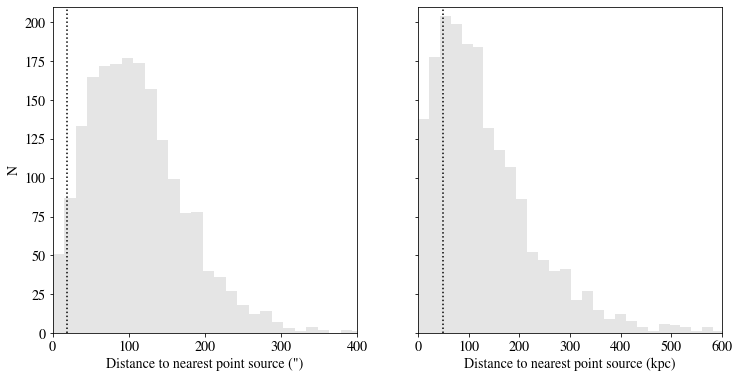

In [565]:
inds = crossmatch(gama, allpts, tab=True)
pts_near_gals = allpts.iloc[inds]
# pts_near_gals
d = dist(pts_near_gals, gama)
dkpc = dist(pts_near_gals, gama, kpc=True)
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12,6))
h1 = ax[0].hist(d, bins=50, color='gray', alpha=0.2)
h2 = ax[1].hist(dkpc, bins=50, color='gray', alpha=0.2)
ax[0].vlines(19.2, 0, 350, color='k', linestyle='dotted')
ax[0].set_xlim(0,400)
ax[1].set_xlim(0,600)
plt.vlines(50, 0, 210, color='k', linestyle='dotted')
plt.ylim(0,210)
ax[0].set_ylabel('N')
ax[0].set_xlabel('Distance to nearest point source (")')
ax[1].set_xlabel('Distance to nearest point source (kpc)')

In [1306]:
gama_all = pd.read_csv('gama_spec.csv', header=0)
inds2 = crossmatch(gama_all, allpts, tab=True)
pts_near_gals2 = allpts.iloc[inds2]
dcont = dist(pts_near_gals2, gama_all)
dkpccont = dist(pts_near_gals2, gama_all, kpc=True)

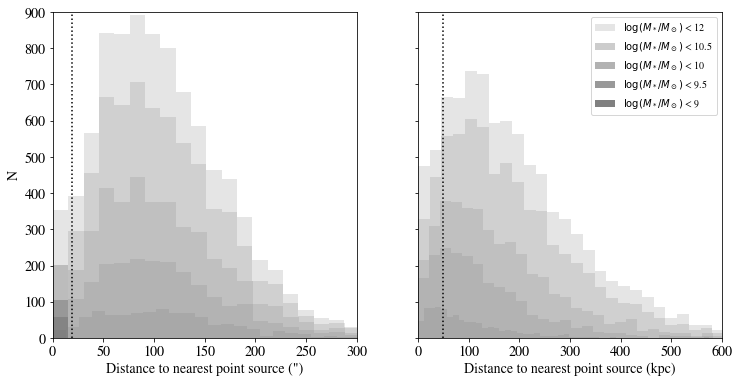

In [1229]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12,6))
h1 = ax[0].hist(dcont, bins=50, color='gray', alpha=0.2, label=r'$\log(M_*/M_\odot)$ < 12')
h2 = ax[1].hist(dkpccont, bins=50, color='gray', alpha=0.2)
h1 = ax[0].hist(dcont[np.log10(gama_all['mass_stellar_best_fit']) < 10.5], bins=50, color='gray', alpha=0.2, label=r'$\log(M_*/M_\odot)$ < 10.5')
h2 = ax[1].hist(dkpccont[np.log10(gama_all['mass_stellar_best_fit']) < 10.5], bins=50, color='gray', alpha=0.2)
h1 = ax[0].hist(dcont[np.log10(gama_all['mass_stellar_best_fit']) < 10], bins=50, color='gray', alpha=0.2, label=r'$\log(M_*/M_\odot)$ < 10')
h2 = ax[1].hist(dkpccont[np.log10(gama_all['mass_stellar_best_fit']) < 10], bins=50, color='gray', alpha=0.2)
h1 = ax[0].hist(dcont[np.log10(gama_all['mass_stellar_best_fit']) < 9.5], bins=50, color='gray', alpha=0.2, label=r'$\log(M_*/M_\odot)$ < 9.5')
h2 = ax[1].hist(dkpccont[np.log10(gama_all['mass_stellar_best_fit']) < 9.5], bins=50, color='gray', alpha=0.2)
h1 = ax[0].hist(dcont[np.log10(gama_all['mass_stellar_best_fit']) < 9], bins=50, color='gray', alpha=0.2, label=r'$\log(M_*/M_\odot)$ < 9')
h2 = ax[1].hist(dkpccont[np.log10(gama_all['mass_stellar_best_fit']) < 9], bins=50, color='gray', alpha=0.2)
ax[0].set_xlim(0,300)
ax[1].set_xlim(0,600)
plt.vlines(50, 0, 900, color='k', linestyle='dotted')
ax[0].vlines(19.2, 0, 900, color='k', linestyle='dotted')
plt.ylim(0,900)
ax[0].set_ylabel('N')
ax[0].set_xlabel('Distance to nearest point source (")')
ax[1].set_xlabel('Distance to nearest point source (kpc)')
h, l = ax[0].get_legend_handles_labels()
h[1].set_alpha(0.4)
h[2].set_alpha(0.6)
h[3].set_alpha(0.8)
h[4].set_alpha(1)
plt.legend(h, l, loc='best')

In [567]:
#What this is telling us is that eFEDS does not find all the SMBH even in the most massive galaxies at z < 0.15. 
#What is the conversion based on AGN duty cycle? ~1e8 yr; so over 1e10 years ~1% of galaxies should be "On".

In [592]:
def focc(dist, rmax=50):
    return len(dist[dist < rmax])/len(dist)

(7.0, 12.0)

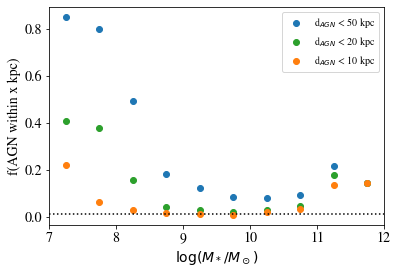

In [1230]:
dm = 0.5
mmin = np.arange(7, 12, dm)
for i in range(len(mmin)):
    f = focc(dkpccont[(np.log10(gama_all['mass_stellar_best_fit']) > mmin[i])*
                      (np.log10(gama_all['mass_stellar_best_fit']) < (mmin[i]+dm))])
    f1 = focc(dkpccont[(np.log10(gama_all['mass_stellar_best_fit']) > mmin[i])*
                      (np.log10(gama_all['mass_stellar_best_fit']) < (mmin[i]+dm))], rmax=20)
    f2 = focc(dkpccont[(np.log10(gama_all['mass_stellar_best_fit']) > mmin[i])*
                      (np.log10(gama_all['mass_stellar_best_fit']) < (mmin[i]+dm))], rmax=10)
    if not i:
        label1 = r'd$_{AGN}$ < 50 kpc'
        label2 = r'd$_{AGN}$ < 20 kpc'
        label3 = r'd$_{AGN}$ < 10 kpc'
    else:
        label1=label2=label3=''
    plt.scatter(mmin[i]+dm/2., f, color='tab:blue', label=label1)
    plt.scatter(mmin[i]+dm/2., f1, color='tab:green', label=label2)
    plt.scatter(mmin[i]+dm/2., f2, color='tab:orange', label=label3)
plt.xlabel(r'$\log(M_*/M_\odot)$')
plt.ylabel(r'f(AGN within x kpc)')
plt.legend()
plt.hlines(0.01, 7, 12, color='k', linestyle='dotted')
plt.xlim(7,12)

The dotted line shows 1%, i.e. the expectation from the quasar duty cycle of 1e8 years. But the highest mass bin has all its AGN within 10 kpc, suggesting the lowest rate of false positives. Then we also have to consider the detection limit.

<ipython-input-1231-b42d2214dda2>:8: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(heatmap.T), origin='lower')


Text(0.5, 1.0, 'AGN within 10 kpc')

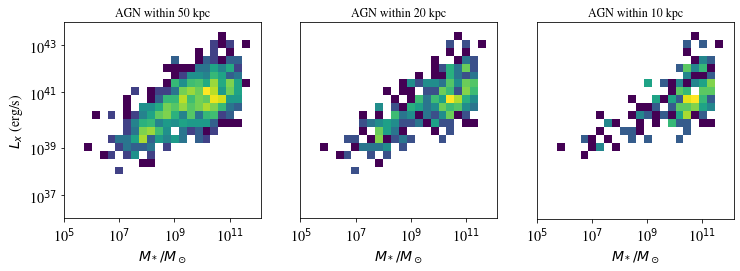

In [1231]:
def Lx_Mstar_heatmap(gama_all, pts_near_gals2, ax,nbins=75):
    dL = 4*np.pi*(lcdm.luminosity_distance(gama_all['Z']).to('cm').value)**2
    Lx = (pts_near_gals2['flux'] * dL).values
    Mstar = gama_all['mass_stellar_best_fit'][Lx>0]
    Lx = Lx[Lx>0]
    heatmap, xedges, yedges = np.histogram2d(np.log10(Mstar), np.log10(Lx), bins=nbins, range=([5,12],[36,44]),density=True)
    extent = [10**xedges[0], 10**xedges[-1], 10**yedges[0], 10**yedges[-1]]
    ax.imshow(np.log10(heatmap.T), origin='lower')
    ax.set_xlabel(r'$M_*/M_\odot$')
    ax.set_ylabel(r'$L_x$ (erg/s)')
    xtix = np.array([5,7,9,11])
    xpos = [np.argmin(abs(xedges - x)) for x in xtix]
    ytix = np.array([37,39,41,43])
    ypos = [np.argmin(abs(yedges - x)) for x in ytix]
    ax.set_xticks(xpos); ax.set_xticklabels([r'10$^{%d}$' % x for x in xtix])
    ax.set_yticks(ypos); ax.set_yticklabels([r'10$^{%d}$' % x for x in ytix])
    ax.set_xlim(0,nbins);ax.set_ylim(0,nbins)
    
fig, ax = plt.subplots(ncols=3, figsize=(12,6))
Lx_Mstar_heatmap(gama_all[dkpccont < 50], pts_near_gals2[dkpccont < 50], ax[0],nbins=25)
Lx_Mstar_heatmap(gama_all[dkpccont < 20], pts_near_gals2[dkpccont < 20], ax[1],nbins=25)
Lx_Mstar_heatmap(gama_all[dkpccont < 10], pts_near_gals2[dkpccont < 10], ax[2],nbins=25)
for a in [ax[1], ax[2]]: a.set_yticks([]), a.set_ylabel('')
ax[0].set_title('AGN within 50 kpc')
ax[1].set_title('AGN within 20 kpc')
ax[2].set_title('AGN within 10 kpc')

<ipython-input-1231-b42d2214dda2>:8: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(heatmap.T), origin='lower')


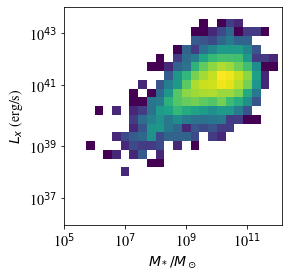

In [1232]:
Lx_Mstar_heatmap(gama_all, pts_near_gals2, plt.gca(),nbins=25)

In [722]:
#so let's use this to find a preliminary scaling relation

In [1236]:
Mstar = gama_all['mass_stellar_best_fit'].values
flim = 6.5e-15 #erg/s/cm**2
#well that is the detection threshhold for a point source

dL = 4*np.pi*(lcdm.luminosity_distance(gama_all['Z']).to('cm').value)**2
Llim = flim*dL/2.
Lx = flim*dL/2.

Lx = (pts_near_gals2['flux'] * dL).values

print(len(Lx), len(Mstar))
fit1, cov1 = np.polyfit(np.log10(Mstar[dcont < 50]), np.log10(Lx[dcont < 50]), 1, cov=True)
fit2, cov2 = np.polyfit(np.log10(Mstar[dcont < 20]), np.log10(Lx[dcont < 20]), 1, cov=True)
fit3, cov3 = np.polyfit(np.log10(Mstar[dcont < 10]), np.log10(Lx[dcont < 10]), 1, cov=True)

8840 8840


In [1237]:
cov1, fit1

(array([[ 0.00035088, -0.00350121],
        [-0.00350121,  0.03514642]]),
 array([ 0.41624726, 37.10827957]))

In [1944]:
def plot(Ms, fit1, cov1, label, alpha, log=True):
    beta_min = fit1[0]-np.sqrt(cov1[0,0])
    beta_max = fit1[0]+np.sqrt(cov1[0,0])
    alpha_min = fit1[1]-np.sqrt(cov1[1,1])
    alpha_max = fit1[1]+np.sqrt(cov1[1,1])
    if log:
        plt.fill_between(10**Ms, 10**(Ms*beta_min + alpha_min),  10**(Ms*beta_max + alpha_max), alpha=alpha)
        plt.loglog(10**Ms,10**(fit1[0]*Ms + fit1[1]), label=label)
    else:
        plt.fill_between(Ms, 10**(Ms*beta_min + alpha_min),  10**(Ms*beta_max + alpha_max), alpha=alpha)
        plt.plot(Ms,10**(fit1[0]*Ms + fit1[1]), label=label)
        plt.yscale('log')

(100000.0, 1000000000000.0)

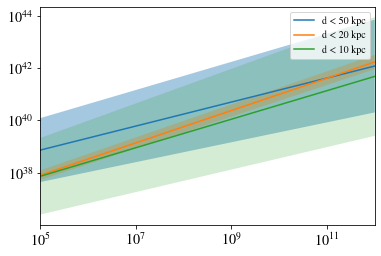

In [1935]:
Ms = np.linspace(5,12,50)
plot(Ms, fit1, cov1, label='d < 50 kpc',alpha=0.4)
plot(Ms, fit2, cov2, label='d < 20 kpc',alpha=0.3)
plot(Ms, fit3, cov3, label='d < 10 kpc',alpha=0.2)
plt.legend()
plt.xlim(1e5,1e12)

So the error bars grow larger with smaller sample number, duh. Normalisation seems to be lower, too.

Text(0.5, 1.0, 'Using galaxies with AGN within 10 kpc of center')

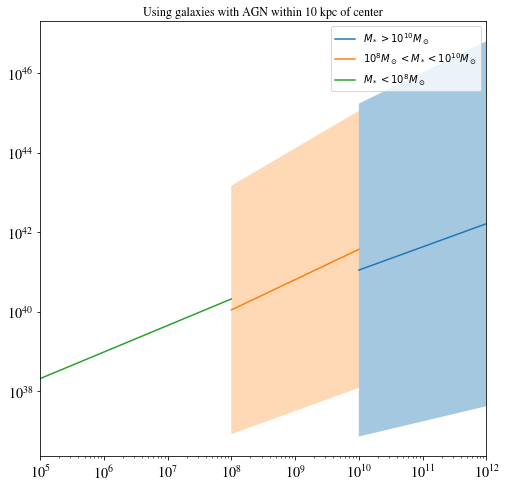

In [1936]:
#Now does this vary with Mstar?
fit1, cov1 = np.polyfit(np.log10(Mstar[(dcont < 5)*(Mstar > 1e10)]), np.log10(Lx[(dcont < 5)*(Mstar > 1e10)]), 1, cov=True)
fit2, cov2 = np.polyfit(np.log10(Mstar[(dcont < 5)*(Mstar > 1e8)*(Mstar < 1e10)]), np.log10(Lx[(dcont < 5)*(Mstar > 1e8)*(Mstar < 1e10)]), 1, cov=True)
fit3, cov3 = np.polyfit(np.log10(Mstar[(dcont < 5)*(Mstar < 1e8)]), np.log10(Lx[(dcont < 5)*(Mstar < 1e8)]), 1, cov=True)

plt.figure(figsize=(8,8))
Ms1 = np.linspace(10,12,50)
Ms2 = np.linspace(8,10,50)
Ms3 = np.linspace(5,8,50)
plot(Ms1, fit1, cov1, label=r'$M_* > 10^{10}M_\odot$',alpha=0.4)
plot(Ms2, fit2, cov2, label=r'$10^{8}M_\odot < M_* < 10^{10}M_\odot$',alpha=0.3)
plot(Ms3, fit3, cov3, label=r'$M_* < 10^{8}M_\odot$',alpha=0.2)
plt.legend()
plt.xlim(1e5,1e12)
plt.title('Using galaxies with AGN within 10 kpc of center')

Text(0.5, 1.0, 'Using galaxies with AGN within 50 kpc of center')

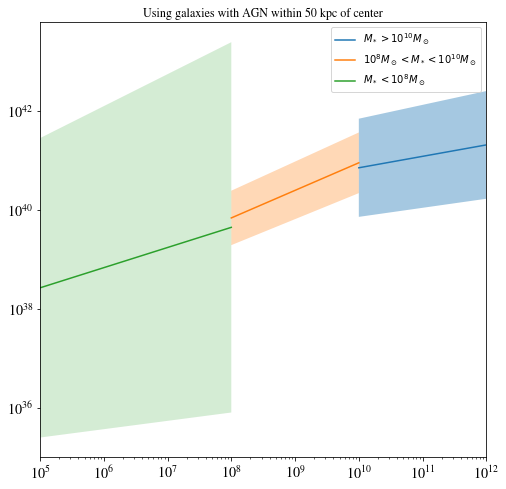

In [1937]:
#Now does this vary with Mstar?
fit1, cov1 = np.polyfit(np.log10(Mstar[(dcont < 50)*(Mstar > 1e10)]), np.log10(Lx[(dcont < 50)*(Mstar > 1e10)]), 1, cov=True)
fit2, cov2 = np.polyfit(np.log10(Mstar[(dcont < 50)*(Mstar > 1e8)*(Mstar < 1e10)]), np.log10(Lx[(dcont < 50)*(Mstar > 1e8)*(Mstar < 1e10)]), 1, cov=True)
fit3, cov3 = np.polyfit(np.log10(Mstar[(dcont < 50)*(Mstar < 1e8)]), np.log10(Lx[(dcont < 50)*(Mstar < 1e8)]), 1, cov=True)

plt.figure(figsize=(8,8))
Ms1 = np.linspace(10,12,50)
Ms2 = np.linspace(8,10,50)
Ms3 = np.linspace(5,8,50)
plot(Ms1, fit1, cov1, label=r'$M_* > 10^{10}M_\odot$',alpha=0.4)
plot(Ms2, fit2, cov2, label=r'$10^{8}M_\odot < M_* < 10^{10}M_\odot$',alpha=0.3)
plot(Ms3, fit3, cov3, label=r'$M_* < 10^{8}M_\odot$',alpha=0.2)
plt.legend()
plt.xlim(1e5,1e12)
plt.title('Using galaxies with AGN within 50 kpc of center')

Text(0.5, 1.0, 'Using galaxies with AGN within 500 kpc of center')

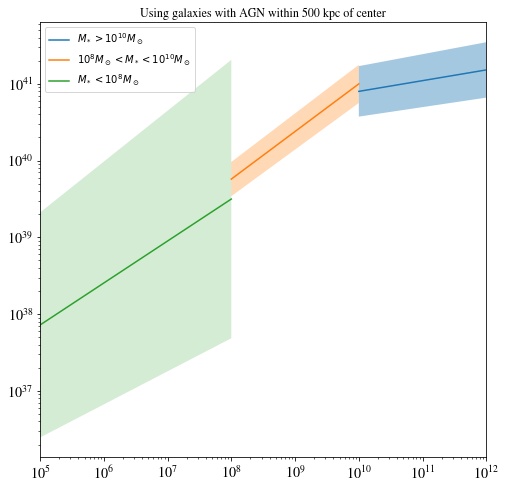

In [1938]:
#Now does this vary with Mstar?
fit1, cov1 = np.polyfit(np.log10(Mstar[(dcont < 500)*(Mstar > 1e10)]), np.log10(Lx[(dcont < 500)*(Mstar > 1e10)]), 1, cov=True)
fit2, cov2 = np.polyfit(np.log10(Mstar[(dcont < 500)*(Mstar > 1e8)*(Mstar < 1e10)]), np.log10(Lx[(dcont < 500)*(Mstar > 1e8)*(Mstar < 1e10)]), 1, cov=True)
fit3, cov3 = np.polyfit(np.log10(Mstar[(dcont < 500)*(Mstar < 1e8)]), np.log10(Lx[(dcont < 500)*(Mstar < 1e8)]), 1, cov=True)

plt.figure(figsize=(8,8))
Ms1 = np.linspace(10,12,50)
Ms2 = np.linspace(8,10,50)
Ms3 = np.linspace(5,8,50)
plot(Ms1, fit1, cov1, label=r'$M_* > 10^{10}M_\odot$',alpha=0.4)
plot(Ms2, fit2, cov2, label=r'$10^{8}M_\odot < M_* < 10^{10}M_\odot$',alpha=0.3)
plot(Ms3, fit3, cov3, label=r'$M_* < 10^{8}M_\odot$',alpha=0.2)
plt.legend()
plt.xlim(1e5,1e12)
plt.title('Using galaxies with AGN within 500 kpc of center')

This last one shouldn't mean anything at all.. and yet it looks like it does.

In [1243]:
# np.nanmax(ptsrc['RADEC_ERR']) #astrometric uncertainty in arcsec
confident = [dcont < pts_near_gals2['xerr']]
#len(gama_all[condifent]) = 75
#these are the matches where the distance between the AGN and galaxy is less than the astrometric error on the AGN
#but the galaxy extent in these galaxies can be up to 50" at z = 0.05, so ~15" at z = 0.15. 
dA = lcdm.angular_diameter_distance(gama_all['Z'])
dA0 = lcdm.angular_diameter_distance(0.045)
close = [dcont < 50*dA0/dA]
len(dcont[close])

<ipython-input-1243-b90262bc6bf9>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  len(dcont[close])


977

Is BPT type in the GAMA catalogue? No, I would have to compute and classify myself using line ratios.

"However, the delineation between these different source
classes, which is defined using theoretical and empirical curves,
is subject to considerable uncertainty, where X-ray detected
AGN have been found in the star-forming region (Agostino &
Salim 2019; LaMassa et al. 2019)"

In [1244]:
Mstar = gama_all.iloc[close[0]]['mass_stellar_best_fit']
z = gama_all.iloc[close[0]]['Z']
heatmap, xedges, yedges = np.histogram2d(np.log10(Mstar), z, bins=(28,30), range=([5,12],[0,.15]),density=True)

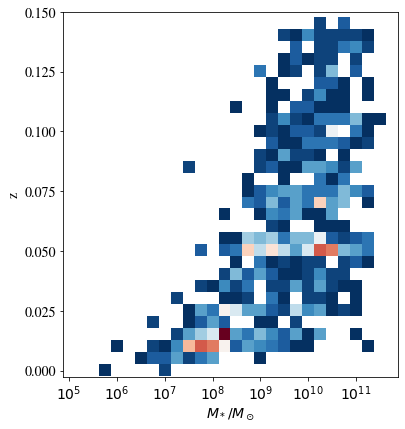

In [1245]:
heatmap[heatmap == 0] = np.nan
fig, ax = plt.subplots(figsize=(6,8))
plt.imshow(heatmap.T, origin='lower', cmap=cm.RdBu_r, norm=colors.Normalize(1,np.nanmax(heatmap)))
plt.xlabel(r'$M_*/M_\odot$')
plt.ylabel('z')
_ = plt.xticks([0,4,8,12,16,20,24], [r'$10^{%d}$' %x for x in [5,6,7,8,9,10,11]])
_ = plt.yticks([0,5,10,15,20,25,30], ['%0.3f' % z for z in [0, .025, 0.05, .075, 0.1,.125, 0.15]])

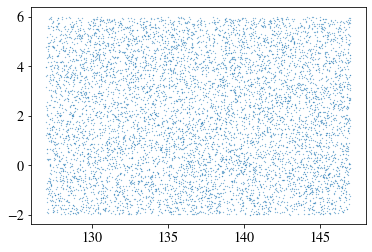

In [870]:
randra = np.random.random(len(gama_all))
randra *= 20
randra += 127
randdec = np.random.random(len(gama_all))
randdec *= 8
randdec -= 2
rand_pos = np.zeros((len(gama_all),2))
rand_pos[:,0] = randra
rand_pos[:,1] = randdec
plt.scatter(randra, randdec, s=0.05)

In [876]:
indrand = crossmatch( rand_pos, allpts, arr=True)

In [877]:
len(indrand), len(rand_pos)

(7628, 7628)

<ipython-input-721-b42d2214dda2>:8: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(heatmap.T), origin='lower')


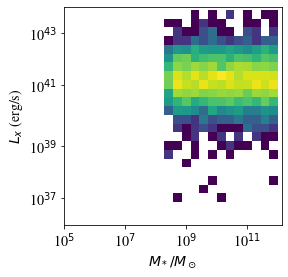

In [880]:
rand_agn = allpts.iloc[indrand]
rand = pd.DataFrame()
rand['mass_stellar_best_fit'] = 10**(np.random.random(len(rand_agn))*7 + 8.5)
rand['Z'] = gama_all['Z']
Lx_Mstar_heatmap(rand, rand_agn, plt.gca(),nbins=25)

(array([1., 0., 0., 0., 0., 0., 1., 0., 8., 7.]),
 array([ 5.94532084,  6.47889209,  7.01246335,  7.5460346 ,  8.07960585,
         8.6131771 ,  9.14674836,  9.68031961, 10.21389086, 10.74746211,
        11.28103337]),
 <BarContainer object of 10 artists>)

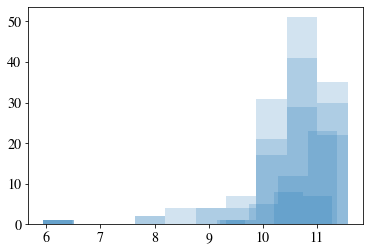

In [1247]:
test = np.log10(gama_all['mass_stellar_best_fit'])[dcont < 5]
plt.hist(test, bins=10, alpha=0.2, color='tab:blue')
test = np.log10(gama_all['mass_stellar_best_fit'])[dcont < 4]
plt.hist(test, bins=10, alpha=0.2, color='tab:blue')
test = np.log10(gama_all['mass_stellar_best_fit'])[dcont < 3]
plt.hist(test, bins=10, alpha=0.2, color='tab:blue')
test = np.log10(gama_all['mass_stellar_best_fit'])[dcont < 2]
plt.hist(test, bins=10, alpha=0.2, color='tab:blue')
test = np.log10(gama_all['mass_stellar_best_fit'])[dcont < 1]
plt.hist(test, bins=10, alpha=0.2, color='tab:blue')

In [889]:
drand = np.sqrt((rand_agn['RA'] - rand_pos[:,0])**2 + (rand_agn['DEC'] - rand_pos[:,1])**2)*3600

In [895]:
# drand = drand.values
#the chance of spurious correlations using various maximum-distances
print(len(drand[drand < 5]), len(drand[drand < 4]), len(drand[drand < 3]), len(drand[drand < 2]), len(drand[drand < 1]))

9 6 5 2 1


In [1307]:
clean_gama = gama_all[dcont < 5]
clean_pts = pts_near_gals2[dcont < 5]
#i.e. we expect 9 of these to be spurious correlations, 8.3%.

In [1308]:
len(clean_gama[clean_gama['mass_stellar_best_fit'] < 3e9]), len(clean_gama[clean_gama['mass_stellar_best_fit'] < 3e8]), len(clean_gama[clean_gama['mass_stellar_best_fit'] < 3e7])

(14, 4, 1)

## MCMC - Fitting Lx-Mstar + occupation function

<ipython-input-1231-b42d2214dda2>:8: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(heatmap.T), origin='lower')


Text(5000000.0, 1e+43, '$\\alpha=36.56\\pm 0.69, \\beta=0.46\\pm 0.01$')

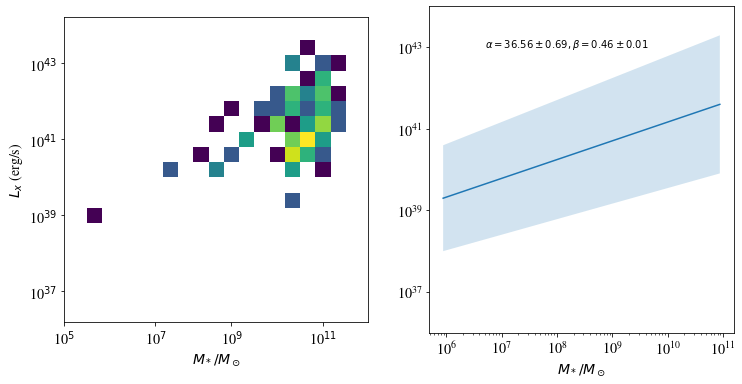

In [1945]:
#prior: use Lx-Mstar by eye
cleandL = 4*np.pi*(lcdm.luminosity_distance(clean_gama['Z']).to('cm').value)**2
cleanLx = (clean_pts['flux'] * cleandL).values
Ms = np.arange(np.log10(clean_gama['mass_stellar_best_fit']).min(), np.log10(clean_gama['mass_stellar_best_fit']).max())
fit1, cov1 = np.polyfit(np.log10(clean_gama['mass_stellar_best_fit']), np.log10(cleanLx), 1, cov=True)
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
Lx_Mstar_heatmap(clean_gama, clean_pts, ax=ax[0],nbins=20)
plot(Ms, fit1, cov1, label='', alpha=0.2)
plt.xlabel(r'$M_*/M_\odot$')
plt.ylim(1e36,1e44)
plt.text(5e6,1e43,r'$\alpha=%0.2f\pm %0.2f, \beta=%0.2f\pm %0.2f$' % (fit1[1],cov1[1,1], fit1[0],cov1[0,0]))

In [1933]:
fit1, cov1**.5

<ipython-input-1933-c375218463c1>:1: RuntimeWarning: invalid value encountered in sqrt
  fit1, cov1**.5


(array([ 0.46034371, 36.55972705]),
 array([[0.07897544,        nan],
        [       nan, 0.82912153]]))

# The sampler 

In [ ]:
def f_occ(Mstar, Mstar0):
    return 0.5 * (1+ np.tanh(pow(2.5, abs(8.9 - np.log10(Mstar0)))*np.log10(Mstar/Mstar0)))

def N(Lx, Mstar, alpha, beta, sigma):
    #likelihood of Lx given scaling relation of slope beta, intercept alpha and scatter sigma
    mu = alpha + beta*np.log10(Mstar)
    rv = norm(loc=mu, scale=sigma)
    return rv.pdf(np.log10(Lx))

def log_likelihood(Lx, Mstar, alpha, beta, sigma, Mstar0):
    return np.log10(f_occ(Mstar, Mstar0)) + np.log10(N(Lx, Mstar, alpha, beta, sigma))
#            * (1 - f_occ(Mstar, Mstar0))*np.kron(np.log10(Lx) + 1e4)      when is Lx going to be 1e4?? pretty nonsensical I think. 

Text(0, 0.5, 'f$_{occ}(M_{*,0})$')

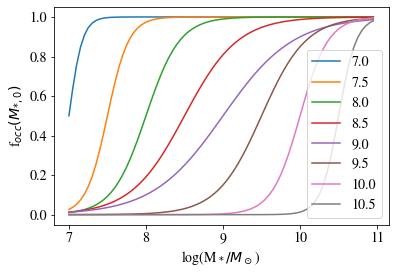

In [1056]:
#test
Mstar = 10**np.arange(7, 11, .05)
for Mstar0 in 10**np.arange(7, 11, .5):
    f = f_occ(Mstar, Mstar0)
    plt.plot(np.log10(Mstar), f, label='%0.1f' % np.log10(Mstar0))

plt.legend()
plt.xlabel(r'log(M$_*/M_\odot$)')
plt.ylabel(r'f$_{occ}(M_{*,0})$')

(5.0, 12.0)

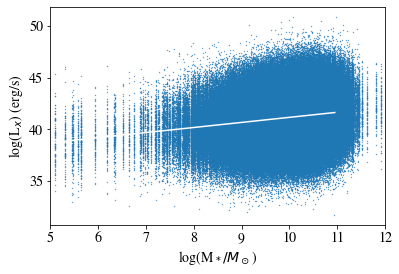

In [1070]:
alpha = 36.26
beta = 0.49
sigma = 2
logMstar = [np.log10(gama_all['mass_stellar_best_fit'].values)][::200][0]
for Mstar in logMstar:
#     print (Mstar)
    mu = alpha + beta*Mstar
    rv = norm(loc=mu, scale=sigma)
    Lx = rv.rvs(100)
    plt.scatter(np.ones(len(Lx))*Mstar, Lx, color='tab:blue', s=0.1)
logMstar = np.arange(5, 11, .05)
plt.plot(logMstar, alpha+beta*logMstar, color='w')
plt.xlabel(r'log(M$_*/M_\odot$)')
plt.ylabel(r'log(L${_x}$) (erg/s)')
plt.xlim(5, 12)

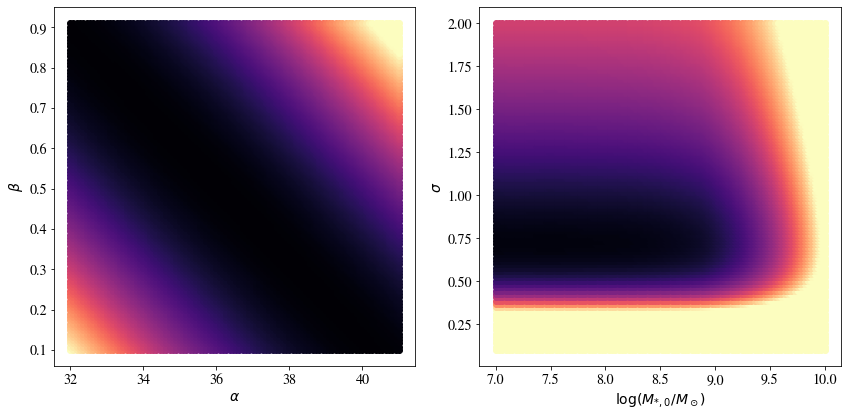

In [1121]:
fig, ax = plt.subplots(ncols = 2, figsize=(12,6))
cmap = cm.magma_r
cnorm = mpl.colors.Normalize(vmin=-1750, vmax=-110)
m = cm.ScalarMappable(norm=cnorm, cmap=cmap)

# l1 = []
Lx = cleanLx
Mstar = clean_gama['mass_stellar_best_fit'].values
i = 0
for alpha in np.linspace(32, 41, 100):
    for beta in np.linspace(0.1, 0.91, 100):
#         l = np.sum(log_likelihood(Lx, Mstar, alpha, beta, sigma=1, Mstar0=1e10))
        ax[0].scatter(alpha, beta, color=m.to_rgba(l1[i]))
        i += 1
#         l1.append(l)
                
# l2 = []
cnorm = mpl.colors.Normalize(vmin=-110, vmax=-60)
m = cm.ScalarMappable(norm=cnorm, cmap=cmap)
i = 0
for sigma in np.linspace(0.1, 2, 100):
    for Mstar0 in 10**np.linspace(7, 10, 100):
#         l = np.sum(log_likelihood(Lx, Mstar, alpha=36.26, beta=.49, sigma=sigma, Mstar0=Mstar0))
        ax[1].scatter( np.log10(Mstar0),sigma, color=m.to_rgba(l2[i]))
        i += 1
#         l2.append(l)

ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel(r'$\beta$')
ax[1].set_xlabel(r'$\log(M_{*,0}/M_\odot)$')
ax[1].set_ylabel(r'$\sigma$')
plt.tight_layout()

The left panel shows the degeneracy between slope and normalisation in the scaling relation, and the right between the scaling relations and the occupation fraction. The latter at least seems bound - we can confidently rule out log(Mstar/Msun) > 9 or so. The left.. the colour bar is wider, could that be a problem?

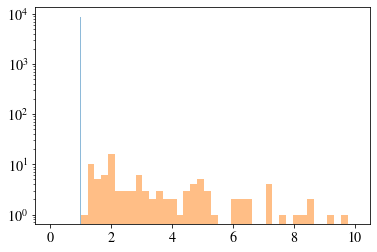

In [1847]:
Mstar = gama_all['mass_stellar_best_fit'].values
flim = 6.5e-15 #erg/s/cm**2
#well that is the detection threshhold for a point source

dL = 4*np.pi*(lcdm.luminosity_distance(gama_all['Z']).to('cm').value)**2
Llim = flim*dL/2.
Lx = flim*dL/2.

Lx[clean_gama.index] = cleanLx

#well yes, for all but 108 of these, Lx IS the detection limit
#but for the other 108 it must be HIGHER
_ = plt.hist(Lx/Llim, range=(0,1), bins=40, alpha=0.5)
_ = plt.hist(cleanLx/Llim[clean_gama.index], range=(1,10), bins=40, alpha=0.5) #ok good.
plt.yscale('log')

#correct.

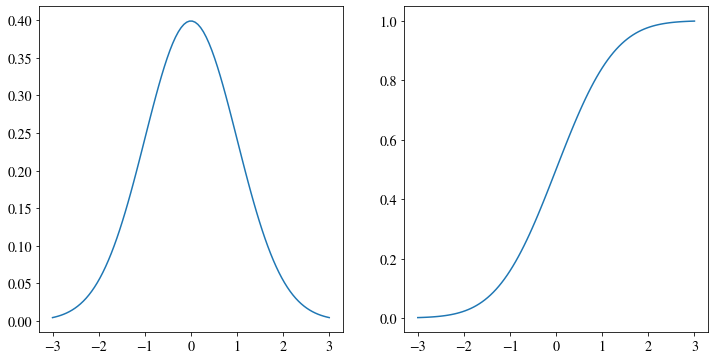

In [1166]:
#checking that I understand the CDF function
x = np.linspace(-3, 3, 100)
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].plot(x, norm.pdf(x))
ax[1].plot(x, norm.cdf(x))

In [ ]:
# I_det = latent(cleanLx, clean_gama['mass_stellar_best_fit'].values, np.zeros(len(clean_gama)),36.26, .5, .75, 1e8)
# I_all = latent(Lx, gama_all['mass_stellar_best_fit'].values, Llim,36.26, .5, .75, 1e8)
# len(I_det), sum(I_det)

_ = plt.hist(I_all, bins=100)

In [1373]:
#OK everything so far has been working as expected I think. So really the issue must be here. Which.. is also the
#step I understand the worst, so bleh. 

#do I treat the 7500 galaxies as non-detections??
def p_BH(Lxi, Mstari, alpha, beta, sigma, Mstar0):
    rv = norm(loc=0, scale=1)
    logLxPred = (alpha + beta*np.log10(Mstari))
    Phi = norm.cdf((np.log10(Lxi) - logLxPred)/sigma)
    focc = f_occ(Mstari, Mstar0)
#     print(1- focc, focc*Phi)
    return Phi/((1 - focc) + focc*Phi)

def latent(Lx, Mstar, Llim, alpha, beta, sigma, Mstar0):
    I_n = np.zeros(len(Mstar))
    for i in range(len(I_n)):
        if Lx[i] > Llim[i]:
            I_n[i] = 1
        else:
            p_true = p_BH(Lx[i], Mstar[i], alpha, beta, sigma, Mstar0)
            if (p_true < 0) or not np.isfinite(p_true):
                p_true = 0
            if p_true > 1:
                p_true = 1
#             print(p_true)
            try:
                I_n[i] = bernoulli.rvs(p_true, size=1)
            except ValueError:
                I_n[i] = 0
    return I_n

def log_prob_Mstar0(Mstar0, I_n, Mstar): #I_n is a list where for each galaxy I_n[i] = 1 if there is a BH and 0 otherwise
    p = 1
    for i in range(len(I_n)):
        focc = f_occ(Mstar[i], Mstar0)
        p *= (np.power(focc, I_n[i]) * np.power(1 - focc, 1-I_n[i]))
    return np.log10(p)


def proposal(theta, i):
    if i ==0:
        low = 32; high = 40
    elif i == 1:
        low = 0.1; high = 2
    elif i == 2:
        low = 0.1; high = 3
    else:
        low = 7; high = 10
    rand = norm(loc=theta, scale = (high-low)/5.) #well this doesn't take into account the previous step. that's why.
    rv = rand.rvs(1)
#     print(rv)
    while (rv < low) or (rv > high):
        rv = rand.rvs(1)
    return rv

def log_pdf(theta, Lx, Mstar, Llim):
    alpha, beta, sigma, logMstar0 = theta
    Mstar0 = 10**logMstar0
    likely = np.sum(log_likelihood(Lx, Mstar, alpha, beta, sigma, Mstar0))
    print("Log likelihood: ", likely/len(Lx))
    I_n = latent(Lx, Mstar, Llim, alpha, beta, sigma, Mstar0)
    print("f_BH: ", sum(I_n)/len(Lx)) #why is this always 1 for everyone?
    prob = log_prob_Mstar0(Mstar0, I_n, Mstar)
    logpdf = (likely + prob)/len(Lx)
    if np.isnan(logpdf):
        return -1e5
    else:
        return logpdf

def run_emcee(Lx, Mstar, Llim, filename, nwalkers=100, ndim=4, nsteps=int(1e4)):
    p0 = np.random.randn(nwalkers, ndim)
    low = [32, .1, .1, 7]
    high = [40, 2, 3, 10]
    for i in range(ndim):
        prange = (p0[:,i].max() - p0[:,i].min())
        p0[:,i] *= (high[i] - low[i])/prange
        p0[:,i] += (low[i] - p0[:,i].min())
    backend = emcee.backends.HDFBackend(filename)
    pool = Pool()
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_pdf, args=[Lx, Mstar, Llim],backend=backend, pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)
    
#so just run run_emcee(Lx, Mstar, Llim)

In [1260]:
#now how do I convert EW to velocity dispersion?
#size of the broad line region
def velocity(line='OIIIR', spec=gama_all):
    lambda_obs = spec['POS_'+line] + spec['HB_CEN']
    dlambda = spec[line+'_EW']
    return dlambda/lambda_obs * 3e5 #c in km/s

(-100.0, 500.0)

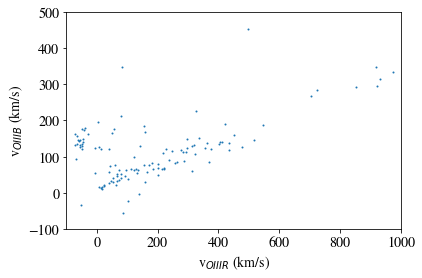

In [1271]:
v_oiiir = velocity('OIIIR', clean_gama)
v_oiiib = velocity('OIIIB', clean_gama)
plt.scatter(v_oiiir, v_oiiib, s=1)
plt.xlabel(r'v$_{OIIIR}$ (km/s)')
plt.ylabel(r'v$_{OIIIB}$ (km/s)')
plt.xlim(-100,1000)
plt.ylim(-100,500)

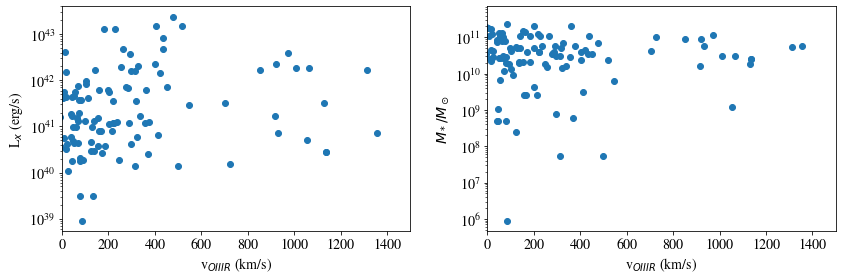

In [1290]:
#this is not really a correlation at all. 
fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(12,4))
cleanLx = pts_near_gals2.iloc[clean_gama.index]['flux'].values * cleandL
ax[0].scatter(v_oiiir, cleanLx)
ax[1].scatter(v_oiiir, clean_gama['mass_stellar_best_fit'])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim(0,1500)
ax[0].set_xlabel(r'v$_{OIIIR}$ (km/s)')
ax[1].set_xlabel(r'v$_{OIIIR}$ (km/s)')
ax[0].set_ylabel(r'L$_x$ (erg/s)')
ax[1].set_ylabel(r'$M_*/M_\odot$')
plt.tight_layout()

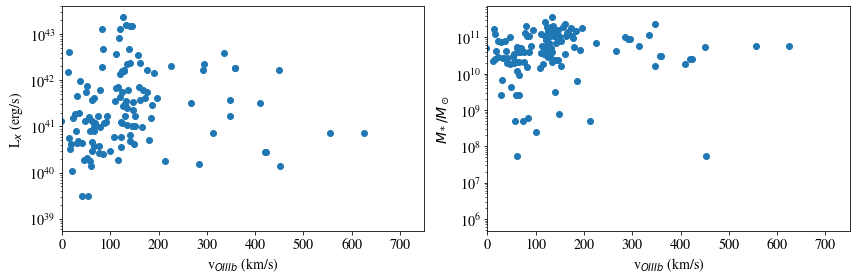

In [1291]:
#this is not any better
fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(12,4))
cleanLx = pts_near_gals2.iloc[clean_gama.index]['flux'].values * cleandL
ax[0].scatter(v_oiiib, cleanLx)
ax[1].scatter(v_oiiib, clean_gama['mass_stellar_best_fit'])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim(0,750)
ax[0].set_xlabel(r'v$_{OIIIB}$ (km/s)')
ax[1].set_xlabel(r'v$_{OIIIB}$ (km/s)')
ax[0].set_ylabel(r'L$_x$ (erg/s)')
ax[1].set_ylabel(r'$M_*/M_\odot$')
plt.tight_layout()

In [1309]:
clean_gama[clean_gama['mass_stellar_best_fit'] < 3e9] #that's >4x more than Latimer+ 2021. 
#only one of these is even possibly in Latimer et al! Doesn't NSA include the GAMA galaxies?
#Note that Miller et al only has 1 bin below 1e10 Msun. 

,CATAID,RA,DEC,Z,sSFR_0_1Gyr_best_fit,mass_stellar_best_fit,OIIIB_EW,OIIIB_EW_ERR,OIIIR_EW,OIIIR_EW_ERR,HB_CEN,POS_OIIIB,POS_OIIIR
1022,216095,136.602665,0.573562,0.0533,2.662000e-10,783500000,2.585640,0.557117,5.216360,0.802178,5223.397954,-0.087321,50.410301
3103,372384,135.559614,1.117435,0.0528,1.445000e-11,2535000000,1.014490,0.254720,2.930710,0.425379,5220.980074,0.347033,50.821301
3104,372384,135.559614,1.117435,0.0528,1.445000e-11,2535000000,1.144680,0.300757,3.770340,0.524916,5220.868530,0.328488,50.801701
3105,372384,135.559614,1.117435,0.0528,1.445000e-11,2535000000,0.498609,0.316034,2.774540,0.547016,5220.913421,0.121005,50.594601
5242,517309,131.723456,2.502639,0.0284,2.302000e-11,505300000,0.980627,0.349233,0.717145,0.343061,5099.975700,0.575787,49.880199
5243,517309,131.723456,2.502639,0.0284,2.302000e-11,505300000,3.621220,1.510960,1.351120,0.905636,5099.864739,-1.614280,47.689098
6299,599077,130.027692,0.345676,0.0517,2.142000e-10,596000000,1.464690,0.368201,6.484770,0.690351,5215.486658,-0.352045,50.069099
7141,801286,130.099668,0.081771,0.1267,1.638000e-09,1091000000,23.862900,4.850450,0.840709,3.768970,5587.493918,-3.763570,50.254002
7150,837766,136.174117,1.394682,0.1103,8.054000e-09,497000000,1.352880,0.984530,0.831724,1.052420,5506.182212,3.095710,56.327202
7158,854435,140.094078,1.257083,0.0038,7.638000e-10,881700,-0.913745,0.942854,1.433920,0.926055,4978.191818,-0.553229,47.573799


Text(0, 0.5, 'L$_x$ (erg/s)')

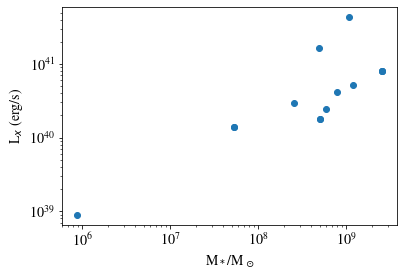

In [1302]:
clean_lowmass = clean_gama[clean_gama['mass_stellar_best_fit'] < 3e9]
plt.scatter(clean_lowmass['mass_stellar_best_fit'], cleanLx[clean_gama['mass_stellar_best_fit'] < 3e9])
plt.xscale('log')
plt.yscale('log')
#ok nice!
plt.xlabel(r'M$_*$/M$_\odot$')
plt.ylabel(r'L$_x$ (erg/s)')

Miller had 87 galaxies at M < 3e9, 6 had detections: log-Lx = [38.7, 40.1,38.4,38.6,38.6,38.6]. Only 1 of these would have crossed the eFEDS detection limit. 

In [1385]:
# !mv /Users/mila/Downloads/Ve* .
vdisp = fits.getdata('VelocityDispersionsv01-2021-10-01.fits')

In [1399]:
inds = []
for i in range(len(gama_all)):
    try:
        inds.append(np.argwhere(vdisp['CATAID'] == gama_all['CATAID'][i])[0])
    except IndexError:
        continue

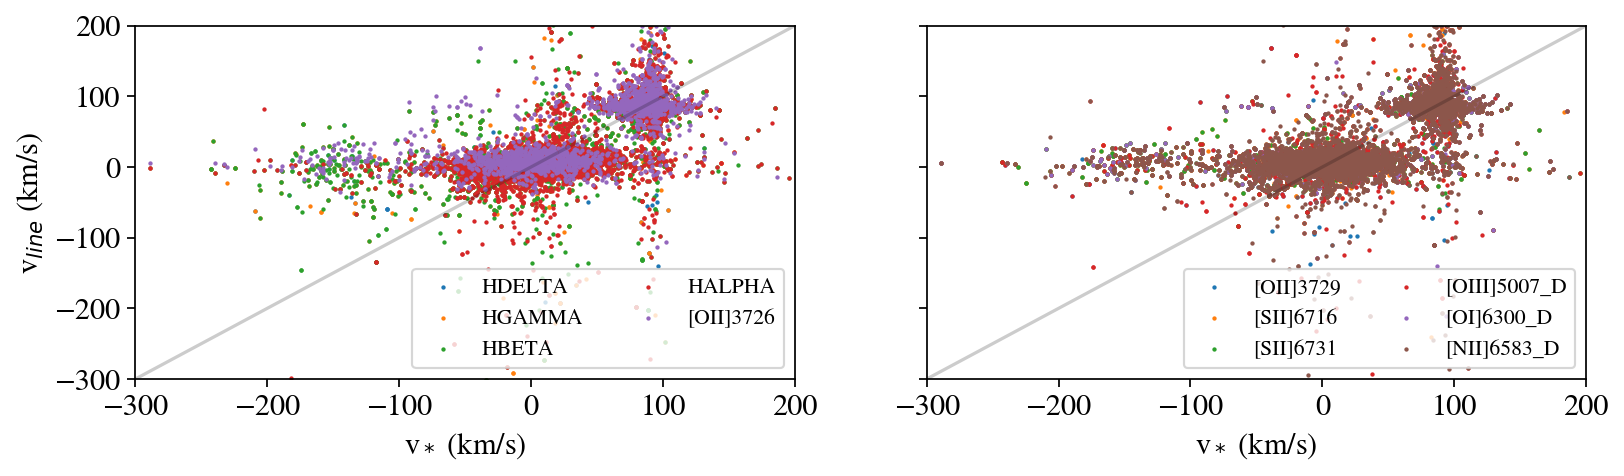

In [1436]:
keys = ['STAR','HDELTA','HGAMMA','HBETA', 'HALPHA','[OII]3726','[OII]3729','[SII]6716','[SII]6731',
        '[OIII]5007_D','[OI]6300_D','[NII]6583_D']
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,3), dpi=156)
for key in keys[1:6]:
    ax[0].scatter(vdisp[inds]['VSTAR'],vdisp[inds]['V'+key], label=key,s=1, alpha=1)
for key in keys[6:]:
    ax[1].scatter(vdisp[inds]['VSTAR'],vdisp[inds]['V'+key], label=key,s=1, alpha=1)
h, l= ax[0].get_legend_handles_labels()
ax[0].legend(h,l, ncol=2)
h, l= ax[1].get_legend_handles_labels()
ax[1].legend(h,l, ncol=2)
ax[0].set_xlabel(r'v$_*$ (km/s)')
ax[1].set_xlabel(r'v$_*$ (km/s)')
ax[0].set_ylabel(r'v$_{line}$ (km/s)')
plt.xlim(-300,200)
plt.ylim(-300,200)
ax[0].plot(np.arange(-1000,1000),np.arange(-1000,1000),color='k',alpha=0.2)
ax[1].plot(np.arange(-1000,1000),np.arange(-1000,1000),color='k',alpha=0.2)

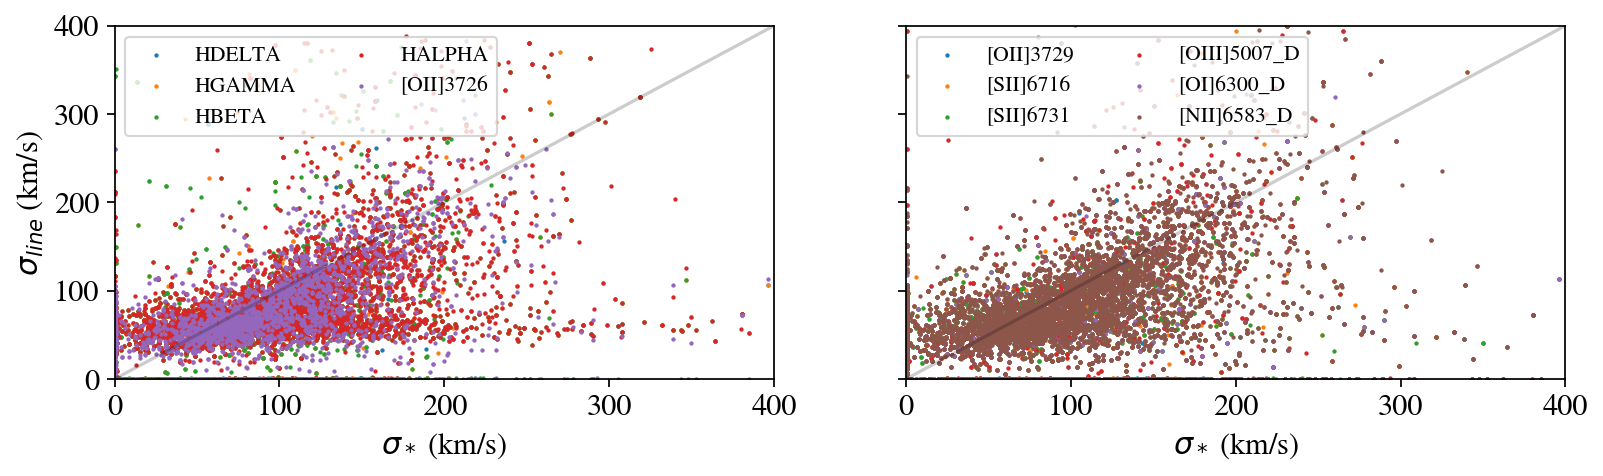

In [1432]:

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,3), dpi=156)
for key in keys[1:6]:
    ax[0].scatter(vdisp[inds]['SIGSTAR'],vdisp[inds]['SIG'+key], label=key,s=1, alpha=1)
for key in keys[6:]:
    ax[1].scatter(vdisp[inds]['SIGSTAR'],vdisp[inds]['SIG'+key], label=key,s=1, alpha=1)
h, l= ax[0].get_legend_handles_labels()
ax[0].legend(h,l, ncol=2)
h, l= ax[1].get_legend_handles_labels()
ax[1].legend(h,l, ncol=2)
ax[0].set_xlabel(r'$\sigma_*$ (km/s)')
ax[1].set_xlabel(r'$\sigma_*$ (km/s)')
ax[0].set_ylabel(r'$\sigma_{line}$ (km/s)')
plt.xlim(0,400)
plt.ylim(0,400)
ax[0].plot(np.arange(400),np.arange(400),color='k',alpha=0.2)
ax[1].plot(np.arange(400),np.arange(400),color='k',alpha=0.2)

In [1415]:
cinds = []
for i in clean_gama.index:
    try:
        cinds.append(np.argwhere(vdisp['CATAID'] == clean_gama['CATAID'][i])[0])
    except IndexError:
        continue

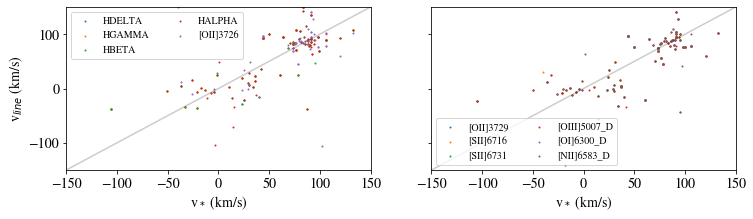

In [1429]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,3))
for key in keys[1:6]:
    ax[0].scatter(vdisp[cinds]['VSTAR'],vdisp[cinds]['V'+key], label=key,s=1, alpha=1)
for key in keys[6:]:
    ax[1].scatter(vdisp[cinds]['VSTAR'],vdisp[cinds]['V'+key], label=key,s=1, alpha=1)
h, l= ax[0].get_legend_handles_labels()
ax[0].legend(h,l, ncol=2)
h, l= ax[1].get_legend_handles_labels()
ax[1].legend(h,l, ncol=2, loc='lower left')
ax[0].set_xlabel(r'v$_*$ (km/s)')
ax[1].set_xlabel(r'v$_*$ (km/s)')
ax[0].set_ylabel(r'v$_{line}$ (km/s)')
plt.xlim(-150,150)
plt.ylim(-150,150)
ax[0].plot(np.arange(-150,150),np.arange(-150,150),color='k', alpha=0.2)
plt.plot(np.arange(-150,150),np.arange(-150,150),color='k', alpha=0.2)

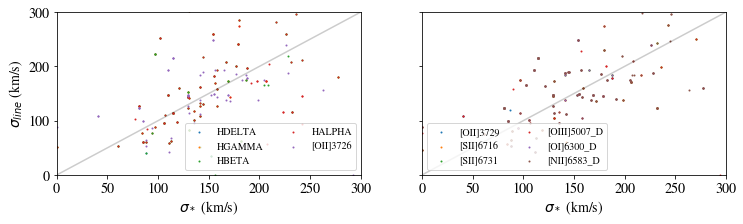

In [1427]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,3))
for key in keys[1:6]:
    ax[0].scatter(vdisp[cinds]['SIGSTAR'],vdisp[cinds]['SIG'+key], label=key,s=1, alpha=1)
for key in keys[6:]:
    ax[1].scatter(vdisp[cinds]['SIGSTAR'],vdisp[cinds]['SIG'+key], label=key,s=1, alpha=1)
h, l= ax[0].get_legend_handles_labels()
ax[0].legend(h,l, ncol=2)
h, l= ax[1].get_legend_handles_labels()
ax[1].legend(h,l, ncol=2, loc='lower left')
ax[0].set_xlabel(r'$\sigma_*$ (km/s)')
ax[1].set_xlabel(r'$\sigma_*$ (km/s)')
ax[0].set_ylabel(r'$\sigma_{line}$ (km/s)')
plt.ylim(0,300)
plt.xlim(0,300)
ax[0].plot(np.arange(300),np.arange(300),color='k', alpha=0.2)
plt.plot(np.arange(300),np.arange(300),color='k', alpha=0.2)

In [1443]:
inds2 = []
for ind in inds:
    try:
        inds2.append(np.argwhere(gama_all['CATAID'].values==vdisp[ind]['CATAID'])[0])
    except IndexError:
        continue
        
inds2 = [ind[0] for ind in inds2]

In [1651]:
s2g = crossmatch(sdss, gama_all, ra1='ra', dec1='dec', tab=True)
len(s2g), len(sdss), len(gama_all)

(8245, 8245, 8840)

In [1661]:
ds2g = ((gama_all.iloc[s2g]['RA'] - sdss['ra'])**2 + (gama_all.iloc[s2g]['DEC'] - sdss['dec'])**2)**.5
ds2g *= 3600
len(ds2g), len(ds2g[ds2g < 10]) #there's really only 1 overlapping source?! I guess that's what Latimer et al found

(14406, 1)

In [2095]:
sdssdL = 4*np.pi*(lcdm.luminosity_distance(sdss['z']).to('cm').value)**2
sdssLlim = flim*sdssdL/2.
sdssLx = flim*sdssdL/2.
inds = crossmatch(sdss, allpts, tab=True, ra1='ra', dec1='dec')
pts_near_sdss = allpts.iloc[inds]
dsdss = dist(pts_near_sdss, sdss, ra='ra', dec='dec')
len(pts_near_sdss[dsdss < 5])

141

In [2107]:
sdsscomplete = pd.DataFrame()
sdsscomplete.insert(0,'ra',sdss['ra'])
sdsscomplete.insert(1,'dec',sdss['dec'])
sdsscomplete.insert(2,'Lx',sdssLx)
sdsscomplete.insert(2,'Llim',sdssLlim)
sdsscomplete.insert(3,'Mstar',10**sdss['logMass'])
sdsscomplete.insert(4,'vstar',sdss['sigmaStars'])
sdsscomplete.insert(5, 'dist', dsdss)
sdsscomplete.insert(2, 'z', sdss['z'])
print(len(sdsscomplete))
_, unique = np.unique(sdsscomplete['ra'], return_index=True)
sdsscomplete = sdsscomplete.iloc[unique]
_, unique = np.unique(sdsscomplete['dec'], return_index=True)
sdsscomplete = sdsscomplete.iloc[unique]
sdsscomplete = sdsscomplete[sdsscomplete['dist'] < 3600]
sdssclean = sdsscomplete[sdsscomplete['dist'] < 5]
sdssdwarfs = sdsscomplete[sdsscomplete['Mstar'] < 1e10]
sdssclean_dwarfs = sdssdwarfs[sdssdwarfs['dist'] < 5]
print(len(sdsscomplete))

8245
6549


In [2106]:
len(np.unique(sdsscomplete['dec']))

6549

In [1648]:
complete = pd.DataFrame()
complete.insert(0,'ra',gama_all.iloc[inds2]['RA'])
complete.insert(1,'dec',gama_all.iloc[inds2]['DEC'])
complete.insert(2,'Lx',Lx[inds2])
complete.insert(2,'Llim',Llim[inds2])
complete.insert(3,'Mstar',Mstar[inds2])
complete.insert(4,'vstar',vdisp[inds]['SIGSTAR'])
complete.insert(5, 'dist', dcont[inds2])
complete.insert(6, 'z', gama_all.iloc[inds2]['Z'])
_, unique = np.unique(complete['ra'], return_index=True)
complete = complete.iloc[unique]

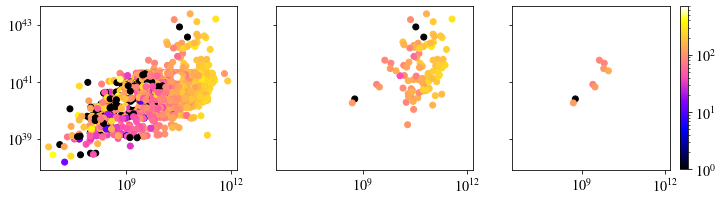

In [1544]:
norm = colors.LogNorm(vmin=1, vmax=700)
cmap = cm.gnuplot2
m = cm.ScalarMappable(norm=norm, cmap=cmap)
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12,3))
ax[0].scatter(complete['Mstar'], complete['Lx'],color= m.to_rgba(complete['vstar']))
ax[1].scatter(clean['Mstar'], clean['Lx'],color= m.to_rgba(clean['vstar']))
im = ax[2].scatter(clean_dwarfs['Mstar'], clean_dwarfs['Lx'],c=clean_dwarfs['vstar'], norm=norm, cmap=cmap)
plt.colorbar(im)
plt.yscale('log')
plt.xscale('log')

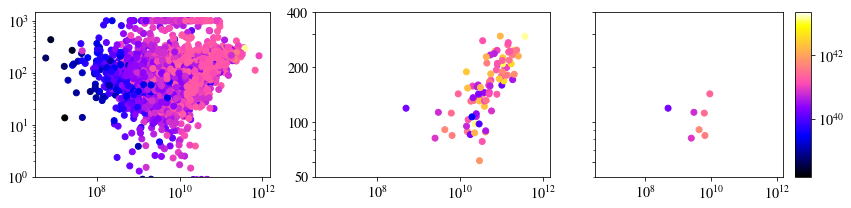

In [1545]:
norm = colors.LogNorm(vmin=Lx.min(), vmax=Lx.max())
cmap = cm.gnuplot2
m = cm.ScalarMappable(norm=norm, cmap=cmap)
fig, ax = plt.subplots(ncols=3, sharex=True, figsize=(12,3))
ax[0].scatter(complete['Mstar'], complete['vstar'], color = m.to_rgba(complete['Lx']))
ax[1].scatter(clean['Mstar'], clean['vstar'], color = m.to_rgba(clean['Lx']))
im = ax[2].scatter(clean_dwarfs['Mstar'], clean_dwarfs['vstar'], c = clean_dwarfs['Lx'], norm=norm, cmap=cmap)
plt.colorbar(im, aspect=10)
for a in ax.flatten():
    a.set_yscale('log')
    a.set_xscale('log')
ax[0].set_ylim(1,1.5e3)
ax[1].set_ylim(50,400)
ax[2].set_ylim(50,400)
plt.yticks([60,100,200,300,400],['','','','',''])
ax[1].set_yticks([50,60,100,200,300,400])
ax[1].set_yticklabels([50,'',100,200,'',400])
plt.tight_layout()

In [1730]:
#now check how much overlap there is between the SDSS and GAMA samples. I really think it's just the 1 galaxy!
cid = crossmatch(sdsscomplete, complete, tab=True, ra1='ra', dec1='dec', ra2='ra', dec2='dec')

delta = np.sqrt((complete.iloc[cid]['ra'].values - sdsscomplete['ra'].values)**2 + 
                (complete.iloc[cid]['dec'].values - sdsscomplete['dec'].values)**2)*3600
len(delta[delta<5]) #ok there are 512 cross-matches within 5", 501 of which are within 1"
#but there are TONS duplicates! well yes, because most are not really matches. this is consistent. 

keep = np.array(cid)[delta > 5]
len(duplicates), len(np.unique(duplicates))
#these IDs need to be removed from the gama table

gama_nosdss = complete.iloc[keep]

In [1876]:
allobs = pd.DataFrame()
allobs.insert(0, 'ra', np.concatenate([gama_nosdss['ra'], sdsscomplete['ra']]))
allobs.insert(1, 'dec', np.concatenate([gama_nosdss['dec'], sdsscomplete['dec']]))
allobs.insert(2, 'z', np.concatenate([gama_nosdss['z'], sdsscomplete['z']]))
allobs.insert(3, 'Mstar', np.concatenate([gama_nosdss['Mstar'], sdsscomplete['Mstar']]))
allobs.insert(4, 'vstar', np.concatenate([gama_nosdss['vstar'], sdsscomplete['vstar']]))
allobs.insert(5, 'Llim', np.concatenate([gama_nosdss['Llim'], sdsscomplete['Llim']]))
allobs.insert(6, 'Lx', np.concatenate([gama_nosdss['Lx'], sdsscomplete['Lx']]))
allobs.insert(7, 'dist', np.concatenate([gama_nosdss['dist'], sdsscomplete['dist']]))
allobs = allobs.drop_duplicates()
# print(len(gama_all.drop_duplicates()), len(gama_nosdss), len(sdsscomplete), len(allobs))
allclean = allobs[allobs['dist'] < 5]
alldwarfs = allobs[allobs['Mstar'] < 1e10]
allclean_dwarfs = alldwarfs[alldwarfs['dist'] < 5]

(5e+37, 5e+42)

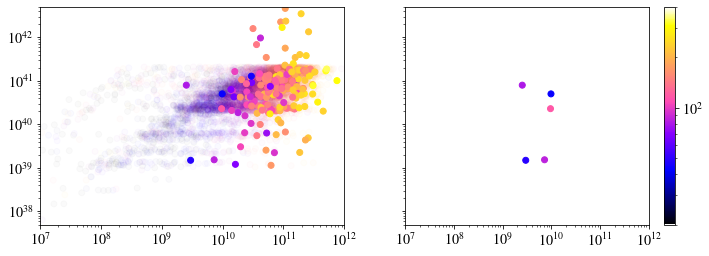

In [1836]:
norm = colors.LogNorm(vmin=20, vmax=400)
cmap = cm.gnuplot2
m = cm.ScalarMappable(norm=norm, cmap=cmap)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,4))
ax[0].scatter(allobs['Mstar'], allobs['Lx'],color= m.to_rgba(allobs['vstar']),alpha=0.02)
ax[0].scatter(allclean['Mstar'], allclean['Lx'],color= m.to_rgba(allclean['vstar']), alpha=1)
im = ax[1].scatter(allclean_dwarfs['Mstar'], allclean_dwarfs['Lx'],c=allclean_dwarfs['vstar'], norm=norm, cmap=cmap)
plt.colorbar(im)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e7,1e12)
plt.ylim(5e37,5e42)

(10000000.0, 1000000000000.0)

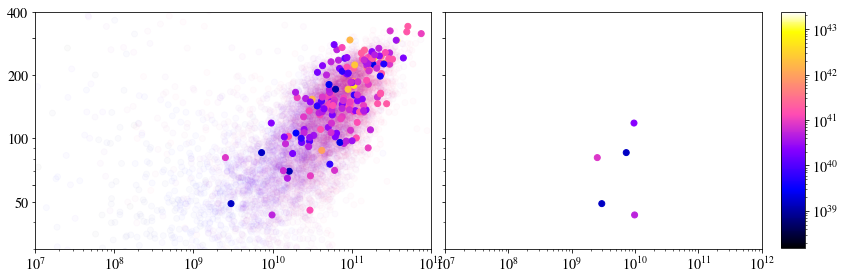

In [1806]:
norm = colors.LogNorm(vmin=Lx.min(), vmax=Lx.max())
cmap = cm.gnuplot2
m = cm.ScalarMappable(norm=norm, cmap=cmap)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,4))
ax[0].scatter(allobs['Mstar'], allobs['vstar'], color = m.to_rgba(allobs['Lx']),alpha=0.02)
ax[0].scatter(allclean['Mstar'], allclean['vstar'], color = m.to_rgba(allclean['Lx']),alpha=1)
im = ax[1].scatter(allclean_dwarfs['Mstar'], allclean_dwarfs['vstar'], c = allclean_dwarfs['Lx'], norm=norm, cmap=cmap)
plt.colorbar(im, aspect=10)
for a in ax.flatten():
    a.set_yscale('log')
    a.set_xscale('log')
ax[0].set_ylim(30, 400)
ax[1].set_ylim(30,400)
plt.yticks([50,60,100,200,300,400],[50,'',100,200,'',400])
# for a in ax.flatten():
#     a.set_yticks()
#     a.set_yticklabels([50,'',100,200,'',400])
plt.tight_layout()
plt.xlim(1e7,1e12)

Text(50, 5e+38, '$\\alpha=40.07\\pm 0.02, \\beta=0.81\\pm 0.03$')

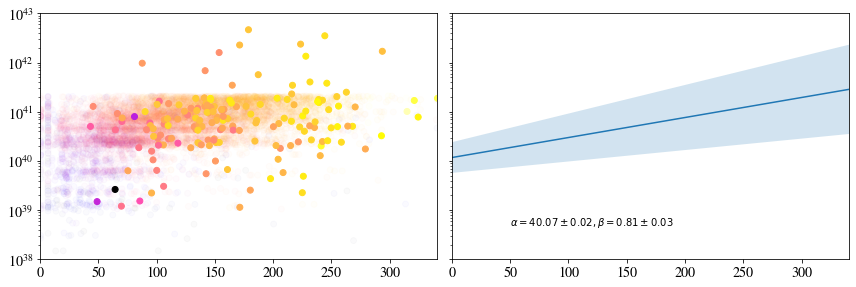

In [2353]:

norm = colors.LogNorm(vmin=1e7, vmax=1e12)
cmap = cm.gnuplot2
m = cm.ScalarMappable(norm=norm, cmap=cmap)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,4))
ax[0].scatter(allobs['vstar'], allobs['Lx'], color = m.to_rgba(allobs['Mstar']),alpha=0.02)
ax[0].scatter(allclean['vstar'], allclean['Lx'], color = m.to_rgba(allclean['Mstar']),alpha=1)

fit1, cov1 = np.polyfit(allclean['vstar']/200, np.log10(allclean['Lx']), 1, cov=True)
nsigma = 2
beta1 = fit1[0]-nsigma*cov1[0,0]**.5
beta2 = fit1[0]+nsigma*cov1[0,0]**.5
alpha1 = fit1[1]-nsigma*cov1[1,1]**.5
alpha2 = fit1[1]+nsigma*cov1[1,1]**.5
lxfit = np.zeros((4, len(vs)))
i = 0 
for a in [alpha1, alpha2]:
    for b in [beta1, beta2]:
        lxfit[i] = 10**((vs/200)*b + a)
        i += 1
        
alpha=0.2
vs = np.linspace(allclean['vstar'].min(), allclean['vstar'].max(), 100)
ax[1].fill_between(vs, np.max(lxfit, axis=0), np.min(lxfit,axis=0), alpha=alpha)
ax[1].plot(vs,10**(fit1[0]*vs/200 + fit1[1]))

for a in ax.flatten():
    a.set_yscale('log')
plt.tight_layout()
plt.xlim(0,allclean['vstar'].max())
plt.ylim(1e38,1e43)
plt.text(50,5e38,r'$\alpha=%0.2f\pm %0.2f, \beta=%0.2f\pm %0.2f$' % (fit1[1],cov1[1,1], fit1[0],cov1[0,0]))

In [2350]:
print(fit1, cov1)

[4.06752116e-03 4.00707554e+01] [[ 7.61982594e-07 -1.27207878e-04]
 [-1.27207878e-04  2.43653775e-02]]


In [1809]:
len(allobs), len(allclean), len(alldwarfs), len(allclean_dwarfs), len(allclean[allclean['Mstar'] < 3e9])

(8515, 171, 1674, 7, 4)

/Users/mila/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'L$_X$ (erg/s)')

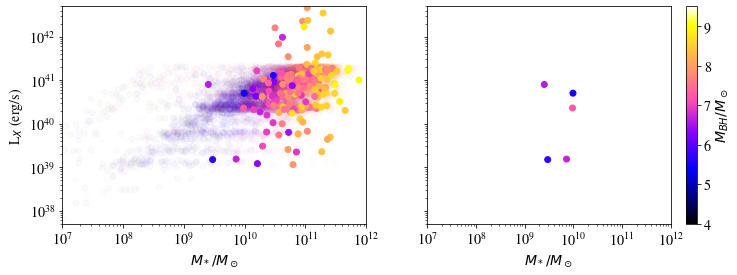

In [1845]:
norm = colors.Normalize(vmin=4, vmax=9.5)
cmap = cm.gnuplot2
m = cm.ScalarMappable(norm=norm, cmap=cmap)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,4))
ax[0].scatter(allobs['Mstar'], allobs['Lx'],color= m.to_rgba(logMbh(allobs['vstar'])),alpha=0.02)
ax[0].scatter(allclean['Mstar'], allclean['Lx'],color= m.to_rgba(logMbh(allclean['vstar'])), alpha=1)
im = ax[1].scatter(allclean_dwarfs['Mstar'], allclean_dwarfs['Lx'],c=logMbh(allclean_dwarfs['vstar']), norm=norm, cmap=cmap)
plt.colorbar(im, label=r'$M_{BH}/M_\odot$')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e7,1e12)
plt.ylim(5e37,5e42)
for a in ax.flatten(): a.set_xlabel(r'$M_*/M_\odot$')
ax[0].set_ylabel(r'L$_X$ (erg/s)')

Text(0, 0.5, 'N')

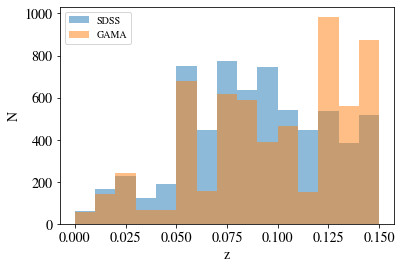

In [1855]:
_ = plt.hist(sdsscomplete['z'], label='SDSS', alpha=0.5, range=(0,.15),bins=15)
_ = plt.hist(gama_nosdss['z'], label='GAMA', alpha=0.5, range=(0,.15),bins=15)
plt.legend()
plt.xlabel('z')
plt.ylabel('N')

(1, 2000)

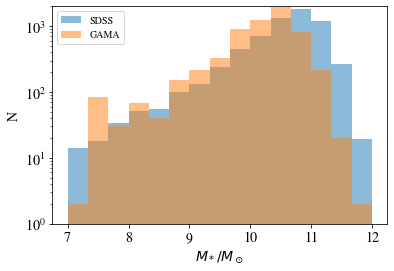

In [2343]:
_ = plt.hist(np.log10(sdsscomplete['Mstar']), label='SDSS', alpha=0.5, range=(7,12),bins=15)
_ = plt.hist(np.log10(gama_nosdss['Mstar']), label='GAMA', alpha=0.5, range=(7,12),bins=15)
plt.legend()
plt.xlabel('$M_*/M_\odot$')
plt.ylabel('N')
plt.yscale('log')
plt.ylim(1,2000)

In [1887]:
# complete.to_csv('gama_all.csv', index=False)
sdsscomplete[sdsscomplete['Mstar'] < 1e5]

,ra,dec,z,Llim,Mstar,vstar,dist,Lx
5045,127.50637,5.825783,0.000221,3.729177e+35,12544.280236,0.000000,1982.641434,3.729177e+35
2695,129.85840,2.277549,0.000171,2.232108e+35,27091.209683,63.108480,154.363203,2.232108e+35
1337,129.89944,2.215628,0.000039,1.186219e+34,3156.539752,0.000000,12.411256,1.186219e+34
6062,130.52887,3.808188,0.000121,1.108952e+35,42244.082656,104.504500,76.626605,1.108952e+35
20,132.08971,0.865153,0.000086,5.661489e+34,4944.355495,0.000000,151.221046,5.661489e+34
3082,132.56135,1.477581,0.000091,6.311772e+34,16271.081397,9.725354,83.636863,6.311772e+34
2698,133.47732,2.893758,0.000038,1.090137e+34,71.395746,24.782980,150.373351,1.090137e+34
1459,133.75615,2.967429,0.000107,8.727277e+34,23053.923907,517.670200,131.995008,8.727277e+34
7790,133.89821,0.819217,0.000218,3.623114e+35,1683.326300,76.602420,133.138870,3.623114e+35
7478,134.00490,5.590053,0.000184,2.576558e+35,25618.405517,21.289650,541.957037,2.576558e+35


In [1947]:
sdsscomplete.to_csv('sdss.csv', index=False)

In [1971]:
from scipy.stats import norm
def logMbh(vstar, alpha=8.33, beta=5.77, eps=0.43, size=1):
#     scaling from McConnell & Ma 2013a
    average = alpha + beta*np.log10(vstar/200)
    dist = norm(loc = average, scale=eps)
    return dist.rvs(size=size)

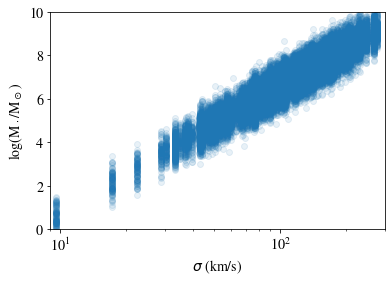

In [1976]:
for sigma in gama_nosdss['vstar'][::10]:
    Mbh = logMbh(sigma, size=100)
    plt.scatter(np.ones(100)*sigma, Mbh, color='tab:blue', alpha=0.1)
plt.xlim(9,300)
plt.ylim(0,10) 
plt.xlabel(r'$\sigma$ (km/s)')
plt.ylabel(r'log(M$_\cdot$/M$_\odot$)')
plt.xscale('log')

In [ ]:
def p_fedd(fedd, Mbh):
    if fedd < fedd0:
        return 1
    elif fedd < fedd_max:
        Mfac = (Mbh/10**7.5)**(-3.3)
        delta = (.20 + .55*Mfac)/(1+Mfac)
        return (fedd/fedd0)**delta

In [1979]:
def logprior():
    if fedd < 1e-10 or fedd > 1e-2:
        return -np.inf

31622776.60168379

In [1999]:
def f_edd(Lx, vstar):
    Mbh = 10**logMbh(vstar)
    Ledd = 1e38 * Mbh
    return Lx/Ledd

fedd = [f_edd(Lx,vstar) for (Lx, vstar) in zip(allclean['Lx'], allclean['vstar'])]

<ipython-input-1971-1376151ff0a7>:3: RuntimeWarning: divide by zero encountered in log10
  average = alpha + beta*np.log10(vstar/200)
<ipython-input-1999-cb4eea723960>:4: RuntimeWarning: divide by zero encountered in true_divide
  return Lx/Ledd


3.209819757490005e-08 0.03408713279580873 0.0004991133690901357 1.3274666327010987e-05 1 1


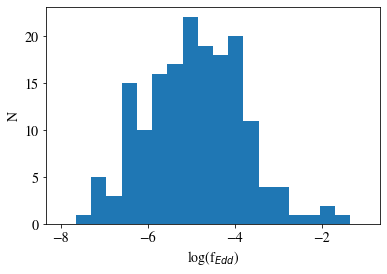

In [2138]:
fedd = np.array(fedd)
print(fedd.min(), fedd[fedd < np.inf].max(), fedd[fedd < np.inf].mean(), np.median(fedd), len(fedd[fedd > 1]), len(fedd[fedd > 2]))
plt.hist(np.log10(fedd), bins=20,range=(-8,-1))
plt.xlabel(r'log(f$_{Edd}$)')
_ = plt.ylabel('N')

In [2005]:
fedd[fedd > .01]

array([0.01187581, 0.03408713, 0.01747399,        inf])

In [2114]:
def pdf(fedd, vstar):
        if fedd < 1e-10:
            return 0
        elif fedd < 1e-5:
            return 1
        else:
            lMbh = logMbh(vstar,eps=0)
            Mfac = (10**(lMbh- 7.5))**(-3.3) #combine equations 14 and 15 of Pesce 2021, ignore z dependence
            delta = -(0.2 + 0.55*Mfac)/(1+Mfac)
#             print(delta)
            return (fedd/1e-5)**delta

In [2139]:
xs = 10**np.linspace(-10,-2,100)

/Users/mila/miniconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/Users/mila/miniconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/Users/mila/miniconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated

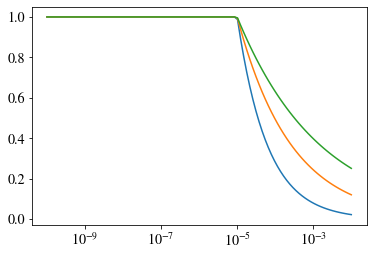

In [2220]:
for v in (50, 150, 300):
    px = [pdf(x, v) for x in xs]
    _ = plt.plot(xs, px, label=v)

_ = plt.xscale('log')

In [2341]:
from scipy.integrate import quad
class p_fedd(stats.rv_continuous):  
        
    def _pdf(self, fedd, vstar):
        fedd0 = 1e-5
        fedd_min = 1e-10
        fedd_max = 0.1
        lMbh = logMbh(vstar,eps=0)
        Mfac = (10**(lMbh- 7.5))**(-3.3) 
            #combine equations 14 and 15 of Pesce 2021, ignore z dependence
        delta = -(0.2 + 0.55*Mfac)/(1+Mfac)
        norm = 1/(np.log10(fedd0/fedd_min) + 
                      (fedd_max**delta - fedd0**delta)/(delta*(fedd0**delta)*np.log(10)))
        
        if (fedd < 1e-10) or (fedd > 1):
            return 0
        else:
            if fedd < 1e-5:
                return norm
            elif fedd < 1e-2:
                return norm*(fedd/1e-5)**delta
            else:
                loglc = np.log(.03)
                sigmac = .88
                denom = 2*np.pi*sigmac*fedd
                exp = (np.log(fedd) - loglc)**2 / (2*sigmac**2)
                return np.exp(-exp)/denom
            
    def _cdf(self, fedd, vstar):
        fedd_min = 1e-10
        fedd_max = 0.1
        intg, _ = quad(self._pdf, fedd_min, fedd, args=(vstar))
        nrm, _ = quad(self._pdf, fedd_min, fedd_max, args=(vstar))
        return intg/nrm

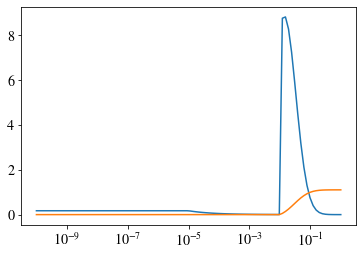

In [2342]:
rv = p_fedd()
x = 10**np.linspace(-10,0,100)
p = [rv.pdf(xi,100) for xi in x]
c = [rv.cdf(xi,100) for xi in x]
plt.plot(x,p)
plt.plot(x,c)
plt.xscale('log') #
#the normalisation of the PDF is off; I have forced the norm in CDF
#but this type of CDF computation is VERY slow, ~20s PER GALAXY
    #i.e. 2.5 HOURS PER STEP
    #absolutely unfeasible. I need an analytic form for this CDF as a function of v

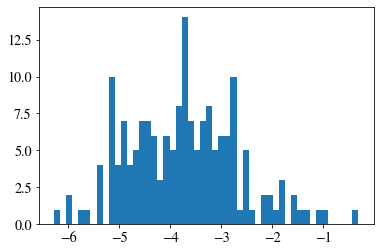

In [2339]:
def log_Mbh(vstar, alpha=8.33, beta=5.77, eps=0.43):
    average = alpha + beta*np.log10(vstar/200)
    return np.array([max(0,norm(loc = av, scale=eps).rvs(size=1)[0]) for av in average])    

def f_edd(Lx, sigma):
	Mbh = 10**log_Mbh(sigma)#the scatter in the M-sigma relationship goes here
	Ledd = 1e38 * Mbh #erg/s, Mbh in Msun
	#also convert this to X-ray luminosity
	Lsun = 4e33 #erg/s
	a = 10.96
	b = 11.93
	c = 17.79 
	kappa = a + (1 + (np.log10(Ledd/Lsun)/b)**c) #Duras+2020
	# print('kappa: ', kappa)
	fedd = kappa*Lx/Ledd
	return fedd

f = f_edd(allclean['Lx'], allclean['vstar'])
_ = plt.hist(np.log10(f), bins=50)

In [2348]:
len(allobs[allobs['vstar']>0]), len(allobs)

(8510, 8515)

In [2361]:
z = allclean['z'][allclean['Mstar'] < 1e10]
5*lcdm.angular_diameter_distance(z.values).to('kpc') * u.arcsec.to('radian')

<Quantity [5.31965407, 1.48330412, 7.52749417, 5.323407  , 1.46365075,
           1.9273199 , 0.01876137] kpc>